In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [2]:
from TO_sim.Get_2ndR_NORM import get_r_rp
from TO_sim.Get_2ndR_Lorentzian import get_r_rp as get_r_rL
from multiprocessing import pool
from parfor import parfor

In [ ]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.005
t = np.arange(0,100,dt)

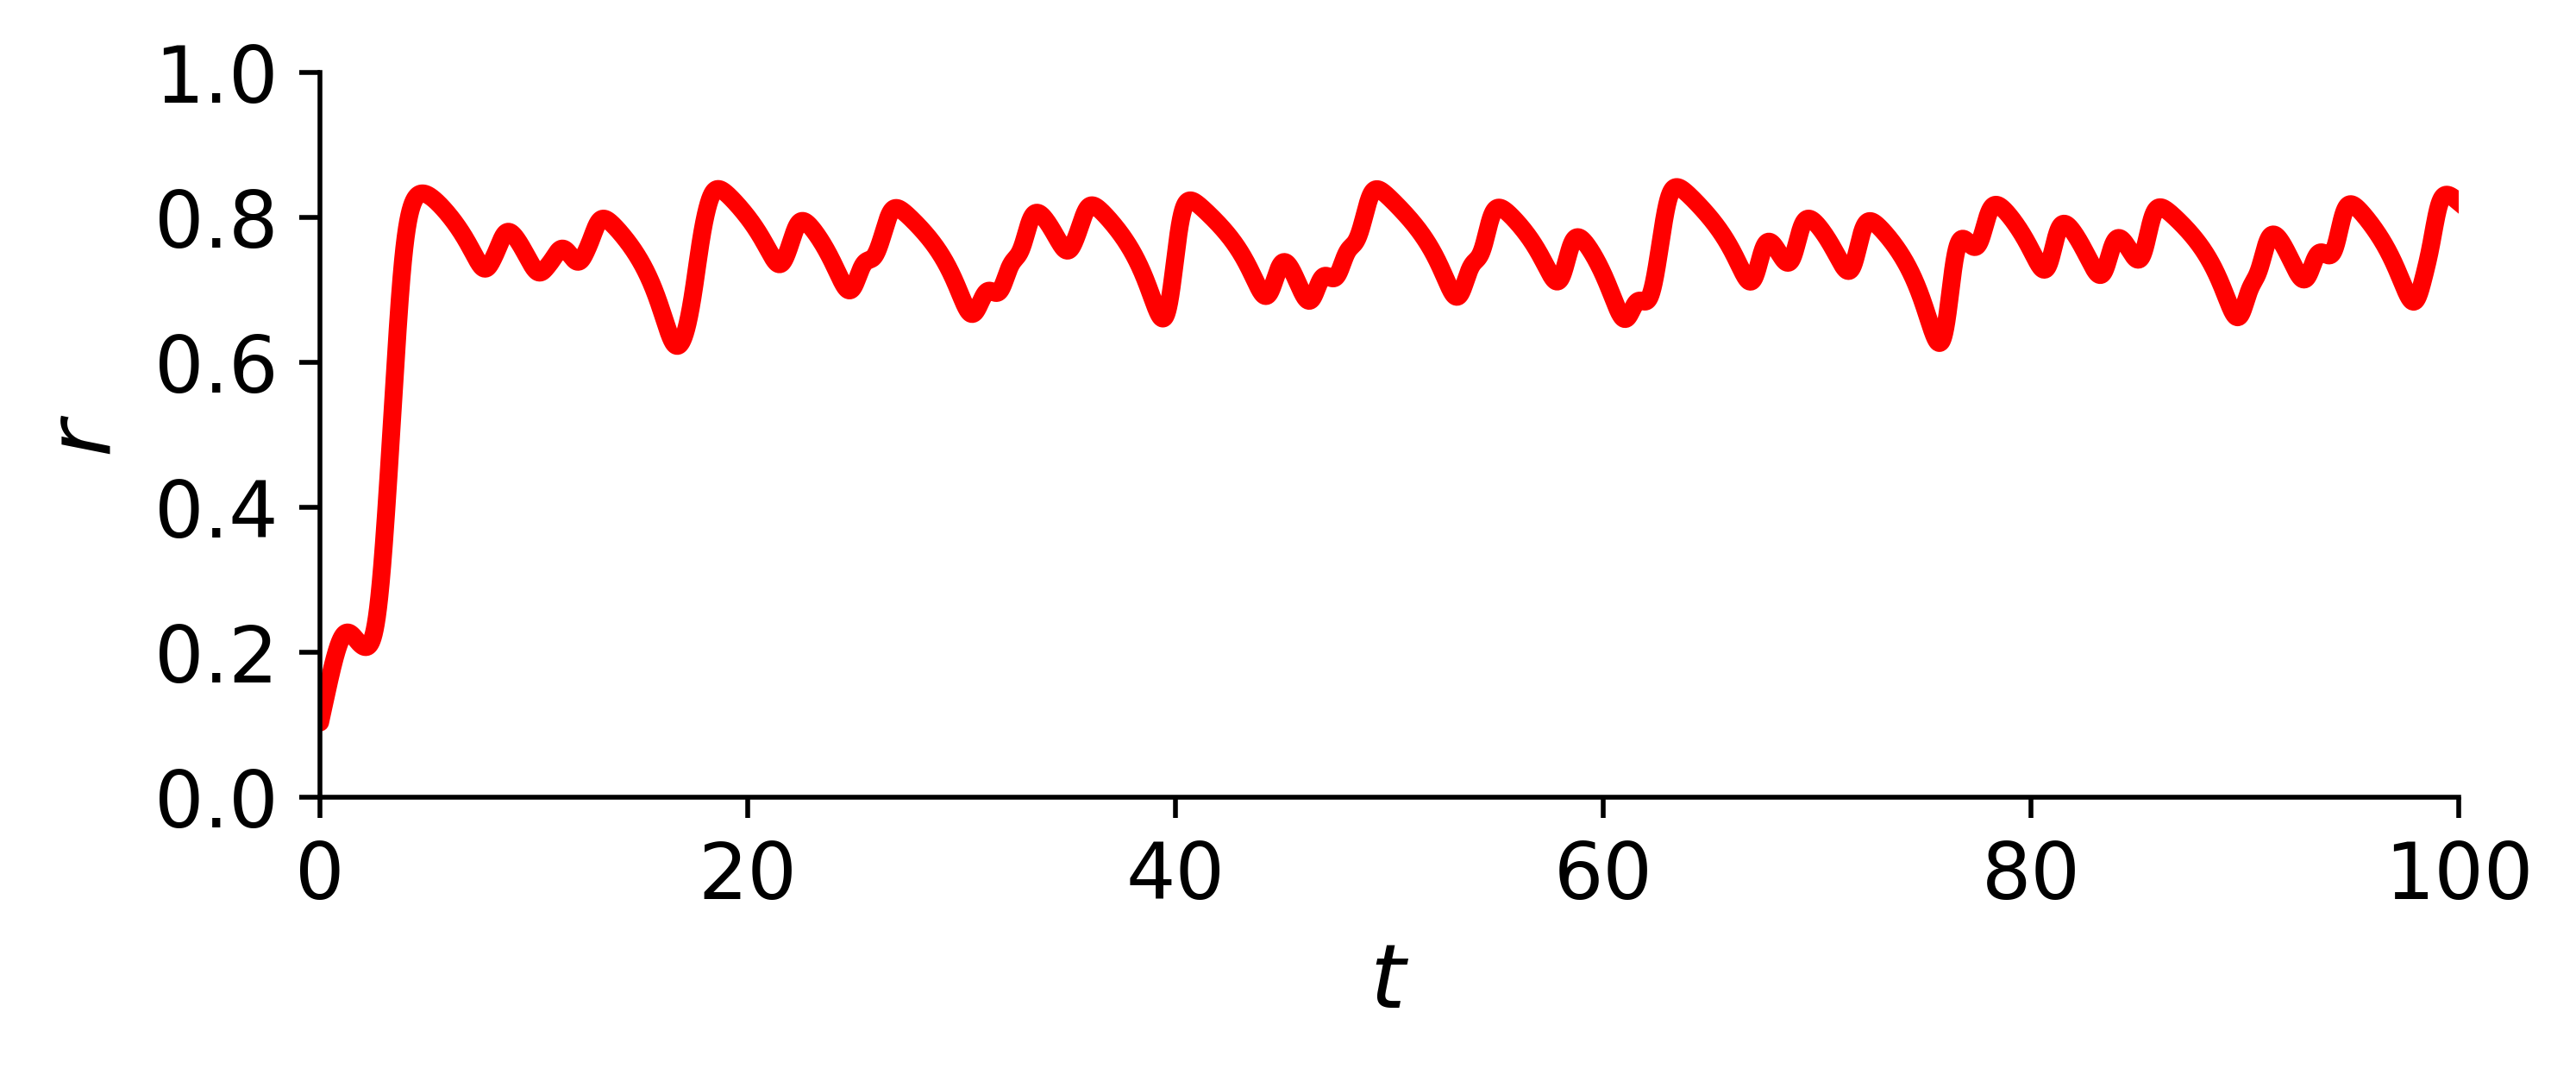

In [304]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [2157]:
def f(x,omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T)
    C = np.mean(np.sin(Ti-Tj),axis=1)
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=0) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K]

def F_j(x,omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    F = np.eye(N+1)
    Ti,Tj = np.meshgrid(T,T)
    CC = np.cos(Tj-Ti)
    SC = np.sum(CC,axis=0)
    SS = np.sum(np.sin(Tj-Ti),axis=0)

    Dii = 1 -K*dt/N*SC
    D = np.r_[Dii,1]
    F[:-1,:-1] = K/N*dt * CC
    F[-1,:-1] = dt/N * SS
    F[:-1,-1] = dt/N * SS
    np.fill_diagonal(F,D)
    return F

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

def H_j(x):
    x = x.copy()
    H = np.zeros((1,N+1))
    T = x[:N]
    CT = np.cos(T)
    ST = np.sin(T)
    X = np.sum(CT)
    Y = np.sum(ST)
    denom = max(1/np.sqrt(N),1/(N*(X**2+Y**2)))
    num = -X*ST + Y*CT
    H[0,:-1] = num/denom
    return H


In [306]:
F = np.eye(N+1)

In [307]:
x = theta[-1]

In [308]:
H_j(x)

array([[ 208.3910892 ,  241.61124381,  288.60834857,  264.55991181,
         238.58899137,  217.56330019,  199.45224659,  183.33272487,
         168.67226555,  155.12882763,  142.46693274,  130.51614873,
         119.1482687 ,  108.26379147,   97.78344108,   87.64259852,
          77.78750458,   68.17258519,   58.75851241,   49.510761  ,
          40.39850581,   31.39375759,   22.47066651,   13.60494371,
           4.77336401,   -4.04667836,  -12.87758413,  -21.74195367,
         -30.66300133,  -39.6649996 ,  -48.77377633,  -58.01729315,
         -67.426342  ,  -77.03540984,  -86.8837822 ,  -97.01698902,
        -107.48874832, -118.36365013, -129.72097184, -141.66028293,
        -154.31000041, -167.84106968, -182.49015626, -198.60209399,
        -216.71641765, -237.77690463, -263.89714909, -288.4687288 ,
        -242.73061436, -224.38613395,    0.        ]])

In [1704]:
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 3
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [2256]:
x = np.r_[theta_random,K -1]
Q = np.eye(N+1)*0
Q[-1,-1] = 0.02
P = np.eye(N+1)*0.01
R_meas = 0.01


P_hats = np.zeros((len(t),*P.shape))
x_hats_KM = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats_KM[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]

for i in range(1,len(t)):
    z_meas = rs[i] + np.random.randn()*R_meas 
    x_bar = f(x,omega)
    F_bar = F_j(x_bar,omega)
    P_bar = F_bar@P@F_bar.T + Q
    P_bar += np.eye(P_bar.shape[0]) * 1e-7
    # 2. EKF 예측 단계
    H = H_j(x_bar)
    z_bar = h(x_bar)
    S = H@P_bar@H.T + R_meas
    S_s[i] =S

    K_gain = P_bar@H.T@np.linalg.inv(S)
    x_hat = x_bar + K_gain@(z_meas-z_bar)
    P_hat = P_bar - K_gain@S@K_gain.T

    x = x_hat
    P = P_hat

    x_hats_KM[i] = x
    P_hats[i] = P
    z_hats[i] = z_bar[0]



/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_8937/3101667693.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S_s[i] =S


In [2257]:
np.mean(x_hats[-500:,-1]) - K

-4.424411133450825

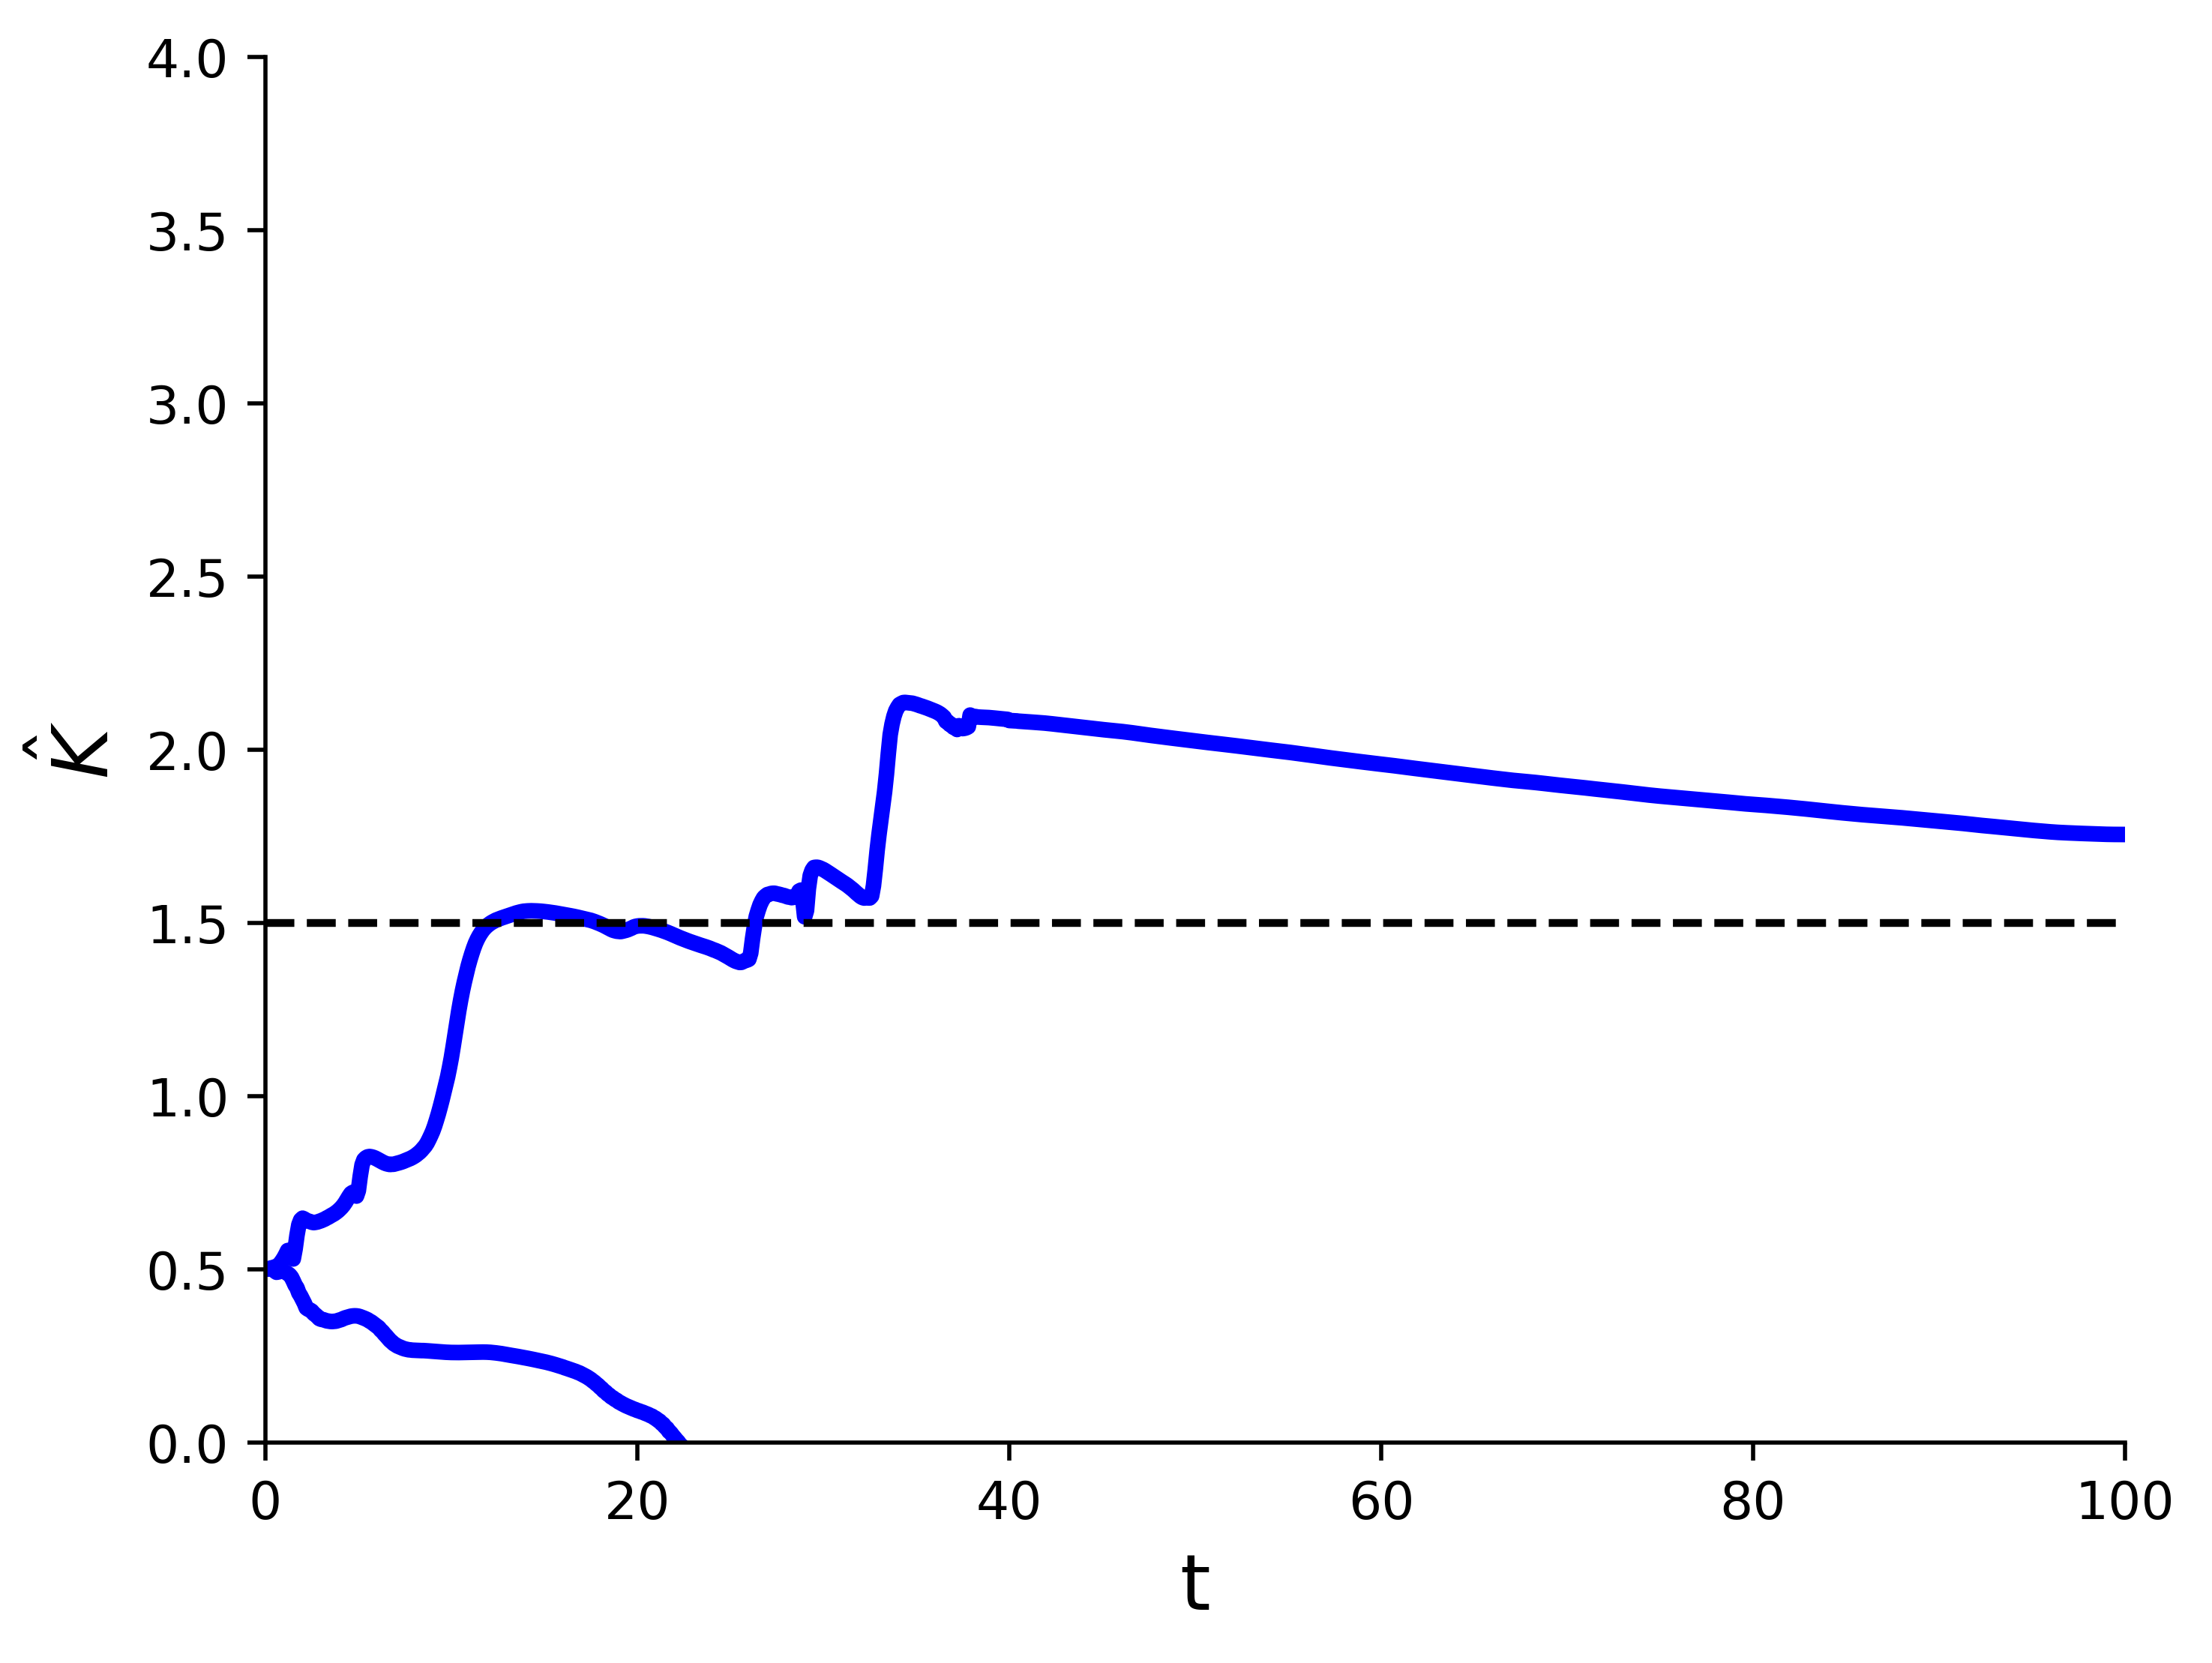

In [2258]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,x_hats_KM[:,-1],color='blue',lw=3)
plt.axhline(K,color='black',ls='--')
plt.ylim(0,4)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [1661]:
theta = (theta+np.pi)%(2*np.pi) - np.pi

Text(0.5, 0, '$t$')

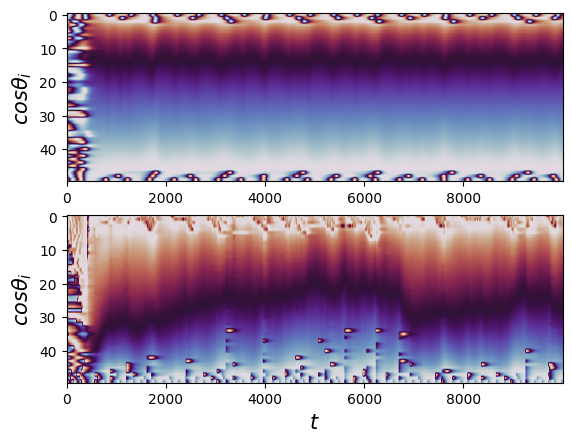

In [1662]:
plt.subplot(211)
plt.imshow(np.cos(theta).T,cmap='twilight')
plt.gca().set_aspect('auto')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.subplot(212)
plt.imshow(np.cos(x_hats[:,:N]).T,cmap='twilight')
plt.ylabel(r'$cos\theta_i$',fontsize=15)

plt.gca().set_aspect('auto')
plt.xlabel(r'$t$',fontsize=15)



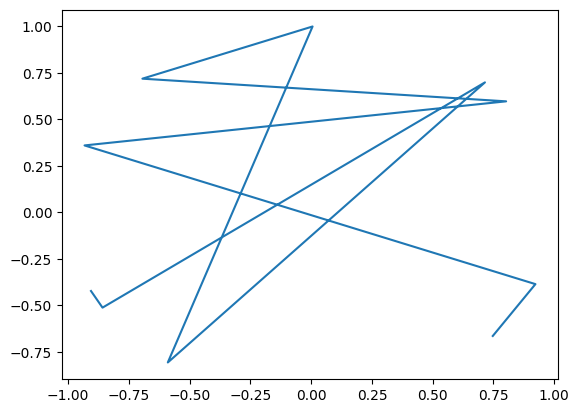

In [298]:
idx = 300
T = x_hats[idx][:N]
plt.plot(np.sin(T),np.cos(T))

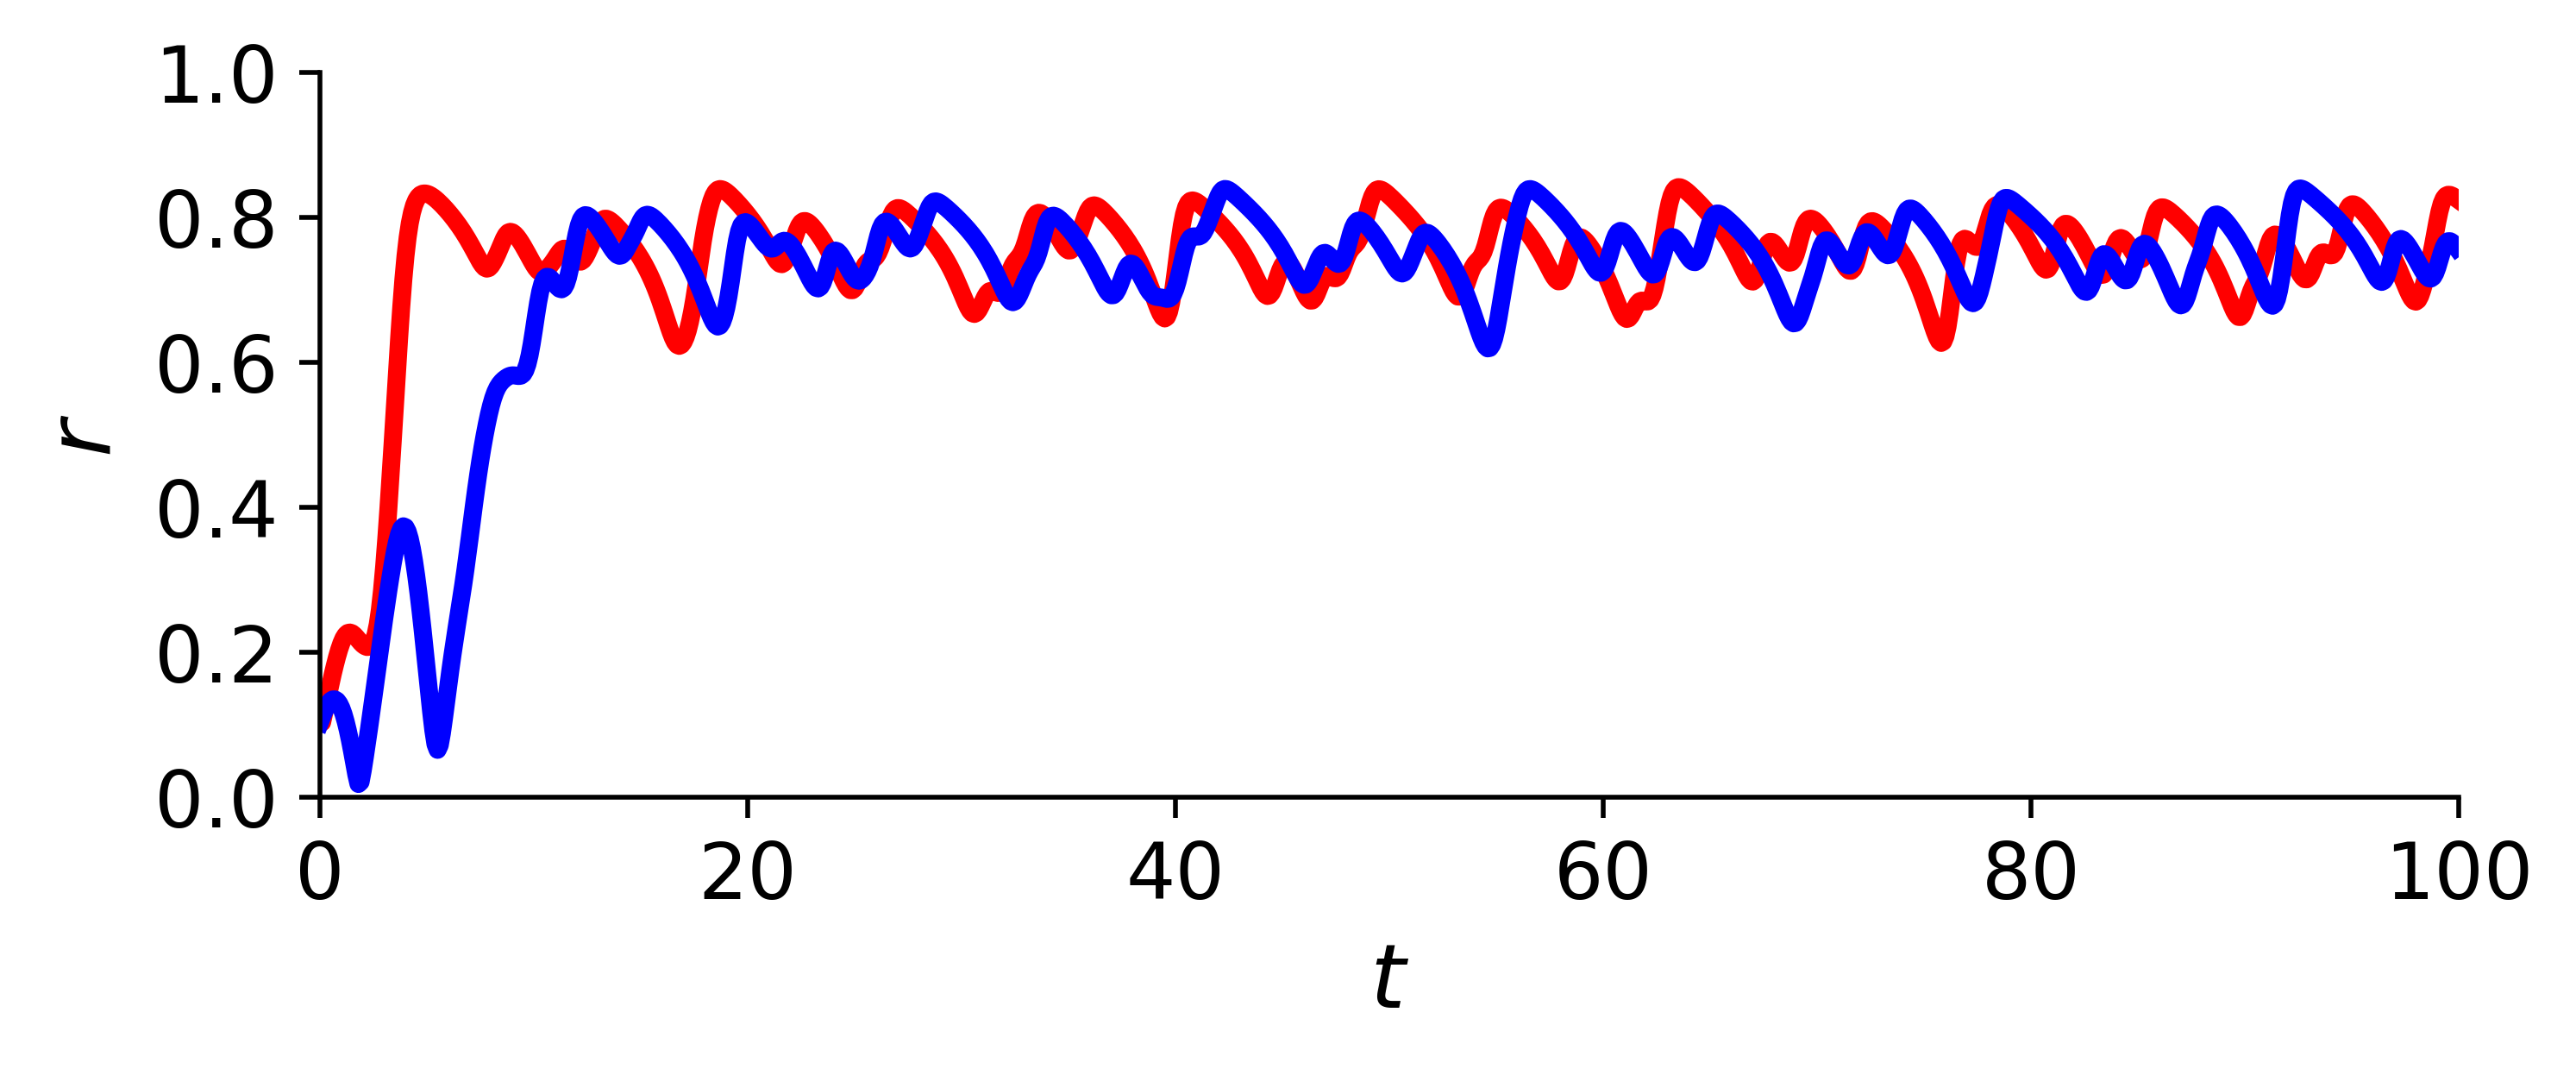

In [1907]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)




# plt.plot(t,rs)

In [51]:
H = np.zeros((1,N+1))
H[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [44]:

# T = x[:N]
# K = x[-1]
F = np.eye(N+1)
Ti,Tj = np.meshgrid(x,x)
CC = np.cos(Tj-Ti)
SC = np.sum(CC,axis=0)
SS = np.sum(np.sin(Tj-Ti),axis=0)

Dii = 1 -K*dt/N*SC
D = np.r_[Dii,1]
F[:-1,:-1] = K/N*dt * CC
F[-1,:-1] = dt/N * SS
F[:-1,-1] = dt/N * SS
np.fill_diagonal(F,D)

# Estimate K with K

In [ ]:
Ks = np.arange(0,4.2,0.4)


11

In [2260]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)

K_rs = []
K_est = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est['r',K] = []
    K_est['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x = np.r_[theta_random,K -1]
        Q = np.eye(N+1)*0
        P = np.eye(N+1)*0.01
        Q[-1,-1] = 0.02
        R_meas = 0.01
        P_hats = np.zeros((len(t),*P.shape))
        x_hats = np.zeros((len(t),len(x)))
        z_hats = np.zeros((len(t)))
        S_s = np.zeros((len(t)))
        x_hats[0] = x
        P_hats[0] = P
        z_hats[0] = h(x)[0]

        for i in range(1,len(t)):
            z_meas = rs[i] + np.random.randn()*R_meas 
            x_bar = f(x,omega)
            F_bar = F_j(x_bar,omega)
            P_bar = F_bar@P@F_bar.T + Q
            P_bar += np.eye(P_bar.shape[0]) * 1e-7
            # 2. EKF 예측 단계
            H = H_j(x_bar)
            z_bar = h(x_bar)
            S = H@P_bar@H.T + R_meas
            S_s[i] =S

            K_gain = P_bar@H.T@np.linalg.inv(S)
            x_hat = x_bar + K_gain@(z_meas-z_bar)
            P_hat = P_bar - K_gain@S@K_gain.T

            x = x_hat
            P = P_hat

            x_hats[i] = x
            P_hats[i] = P
            z_hats[i] = z_bar[0]
        K_estm = np.mean(x_hats[-500:,-1]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_estm,r_estm
    K_ests,r_ests = zip(*get_r_K_mean)
    K_est['K',K] = K_ests
    K_est['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

In [2261]:
df = pd.DataFrame(K_est)

In [2262]:
q1 = df['K'].quantile(0.25)
q2 = df['K'].quantile(0.5)
q3 = df['K'].quantile(0.75)
iqr = q3 - q1
iqr

0.0    0.045165
0.2    0.028057
0.4    0.039459
0.6    0.028317
0.8    0.127342
1.0    0.116247
1.2    0.246900
1.4    0.313793
1.6    0.034321
1.8    0.004882
2.0    0.011006
2.2    0.003366
2.4    0.003161
2.6    0.004256
2.8    0.004148
3.0    0.003577
3.2    0.020074
3.4    0.020805
3.6    0.020010
3.8    0.017893
4.0    0.011462
dtype: float64

In [2263]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

In [2264]:
df_EKF = df

In [2265]:
import seaborn as sns

In [466]:
from scipy.stats import norm

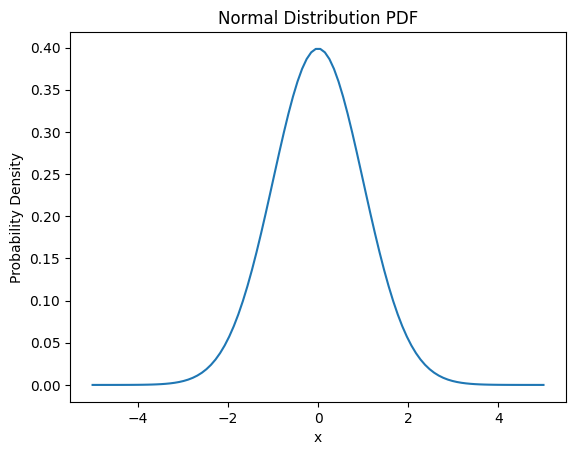

In [2266]:
from scipy.stats import norm

# 평균 0, 표준편차 1인 정규분포의 pdf 계산
x = np.linspace(-5, 5, 100)
pdf = norm.pdf(x, loc=0, scale=1)

plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Normal Distribution PDF')
plt.show()

In [2326]:
df = df_EKF

In [2267]:
K_c = 2/(np.pi*norm.pdf(0,0,1))

(-0.5, 0.5)

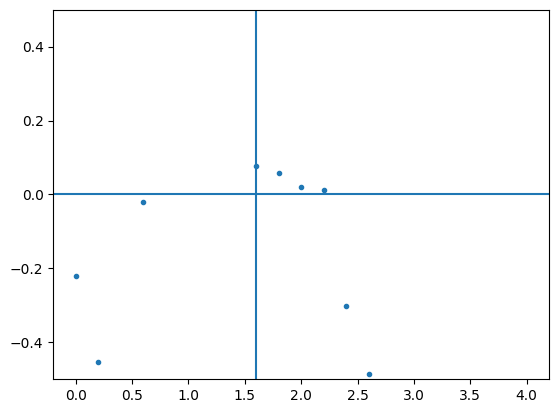

In [2328]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)
plt.ylim(-0.5,0.5)

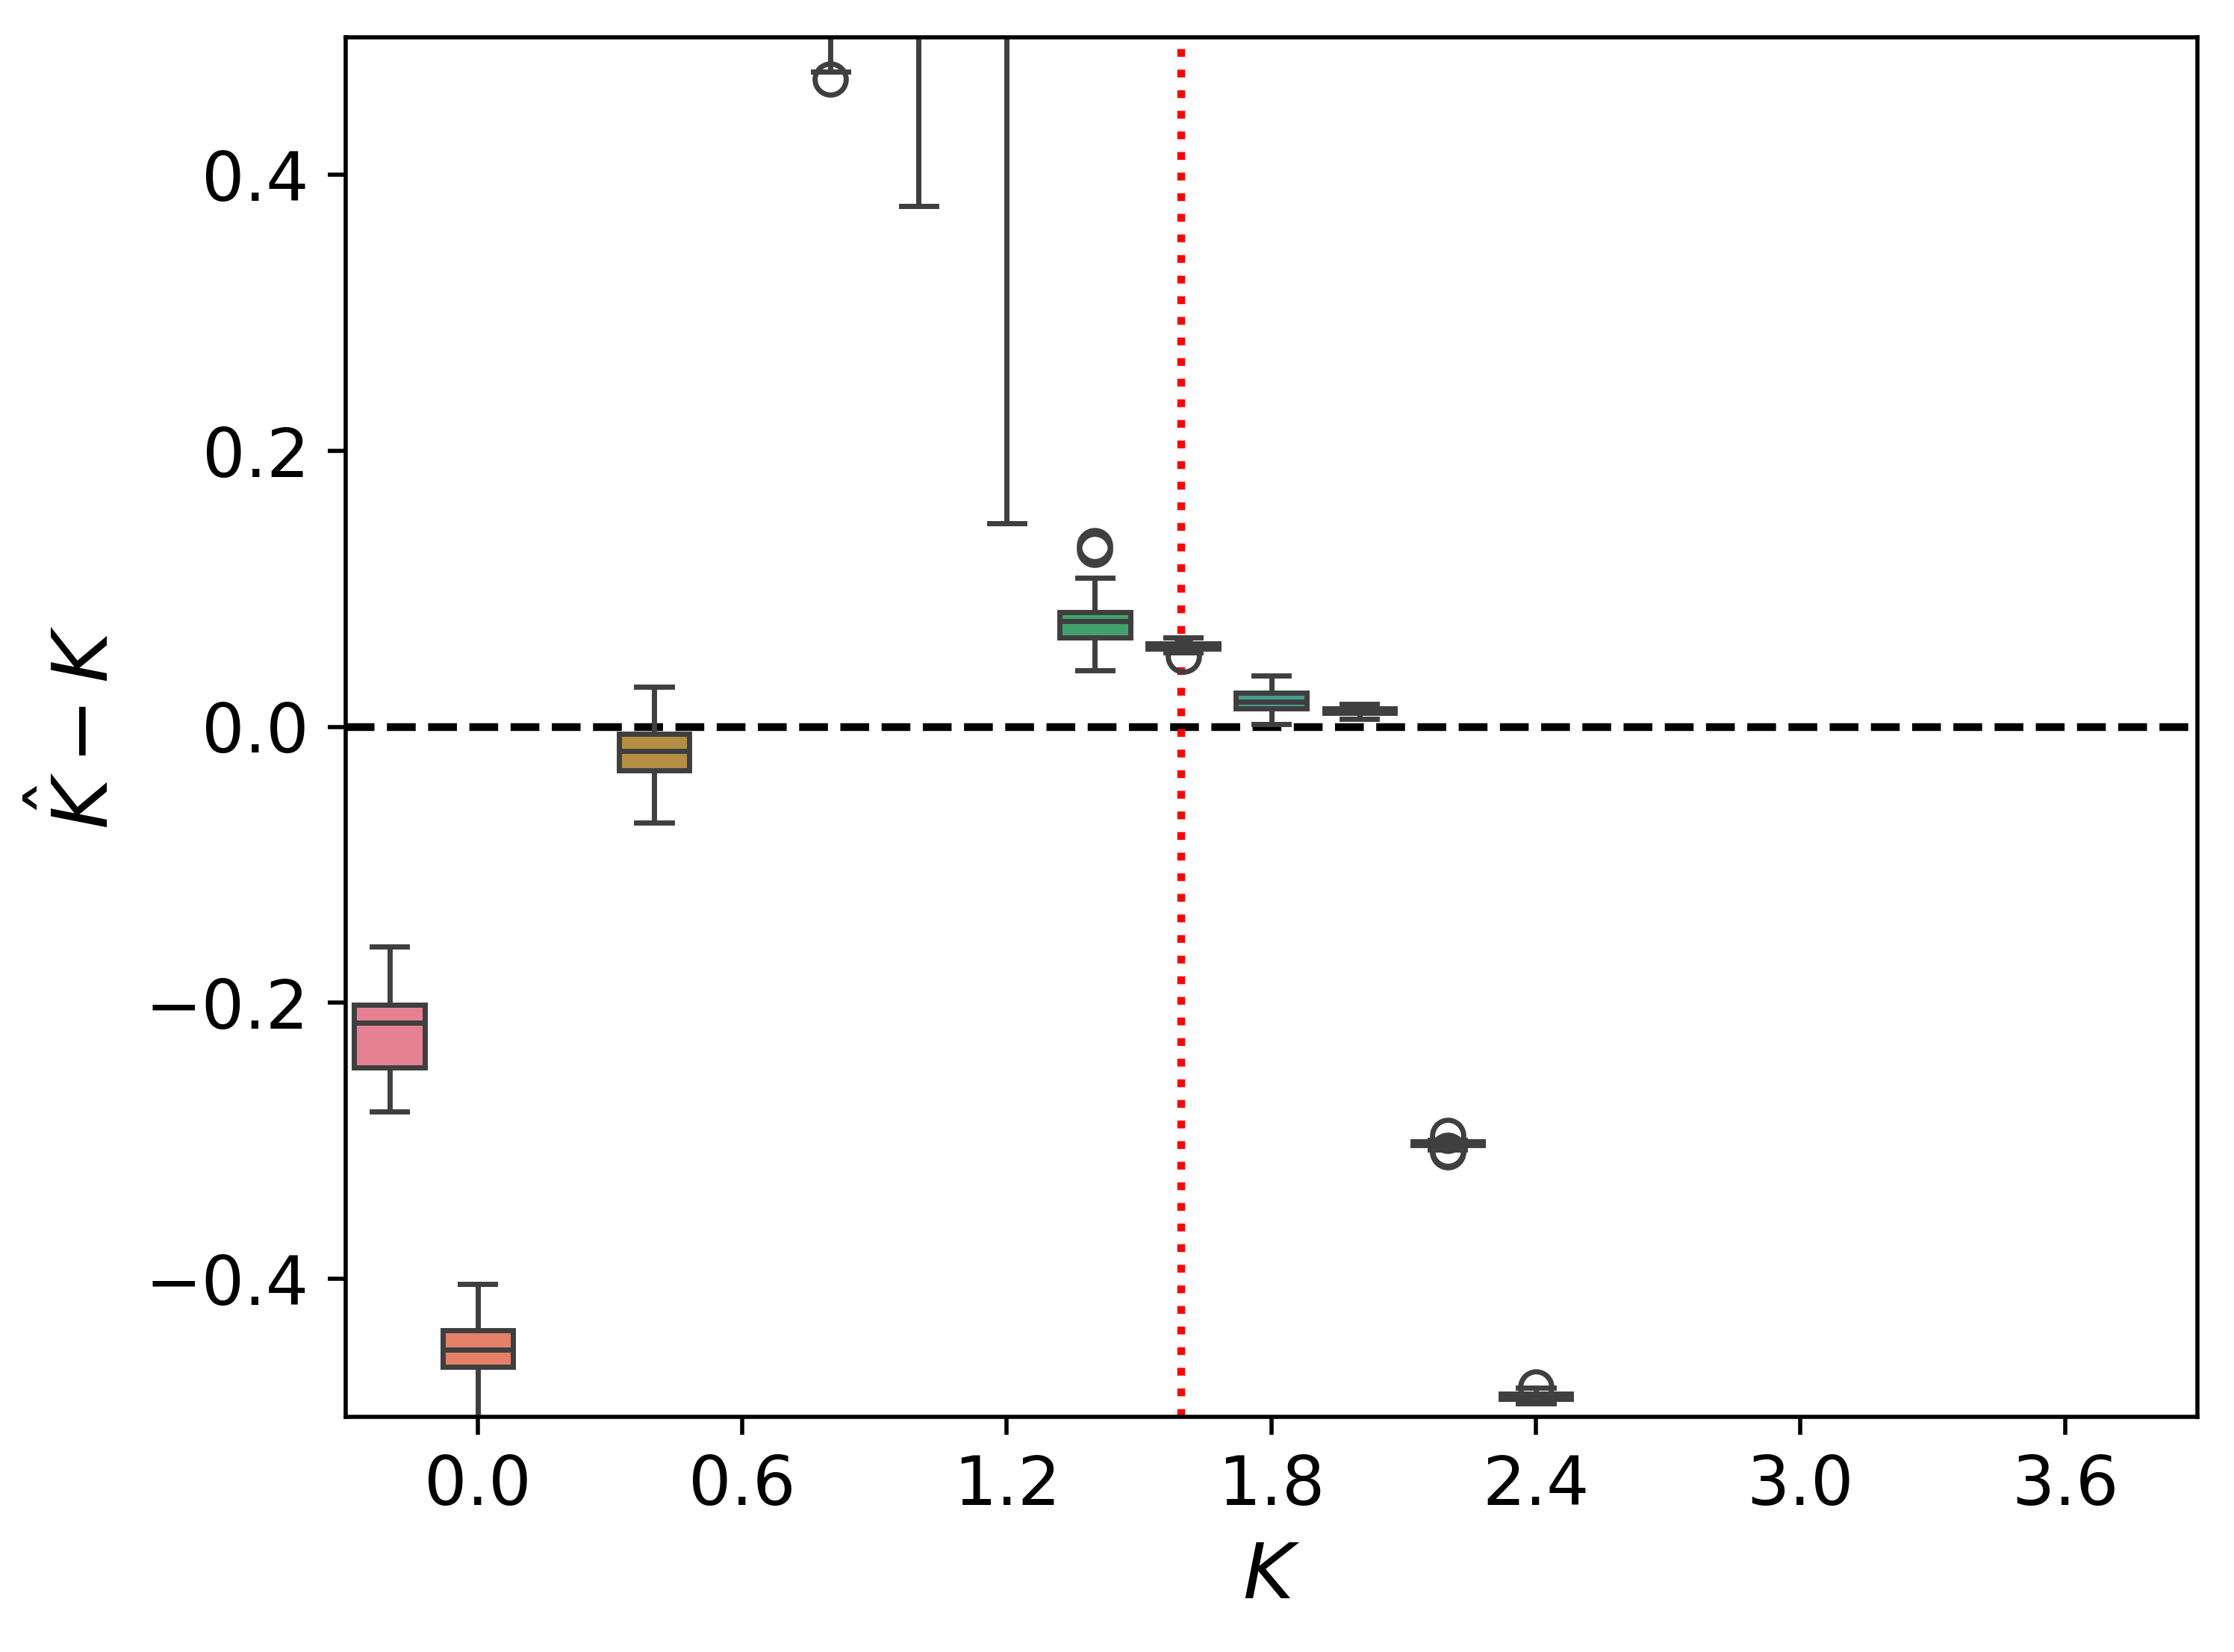

In [2329]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.2+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
# plt.title('Box plot of KK - Ks')
plt.ylim(-0.5,0.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

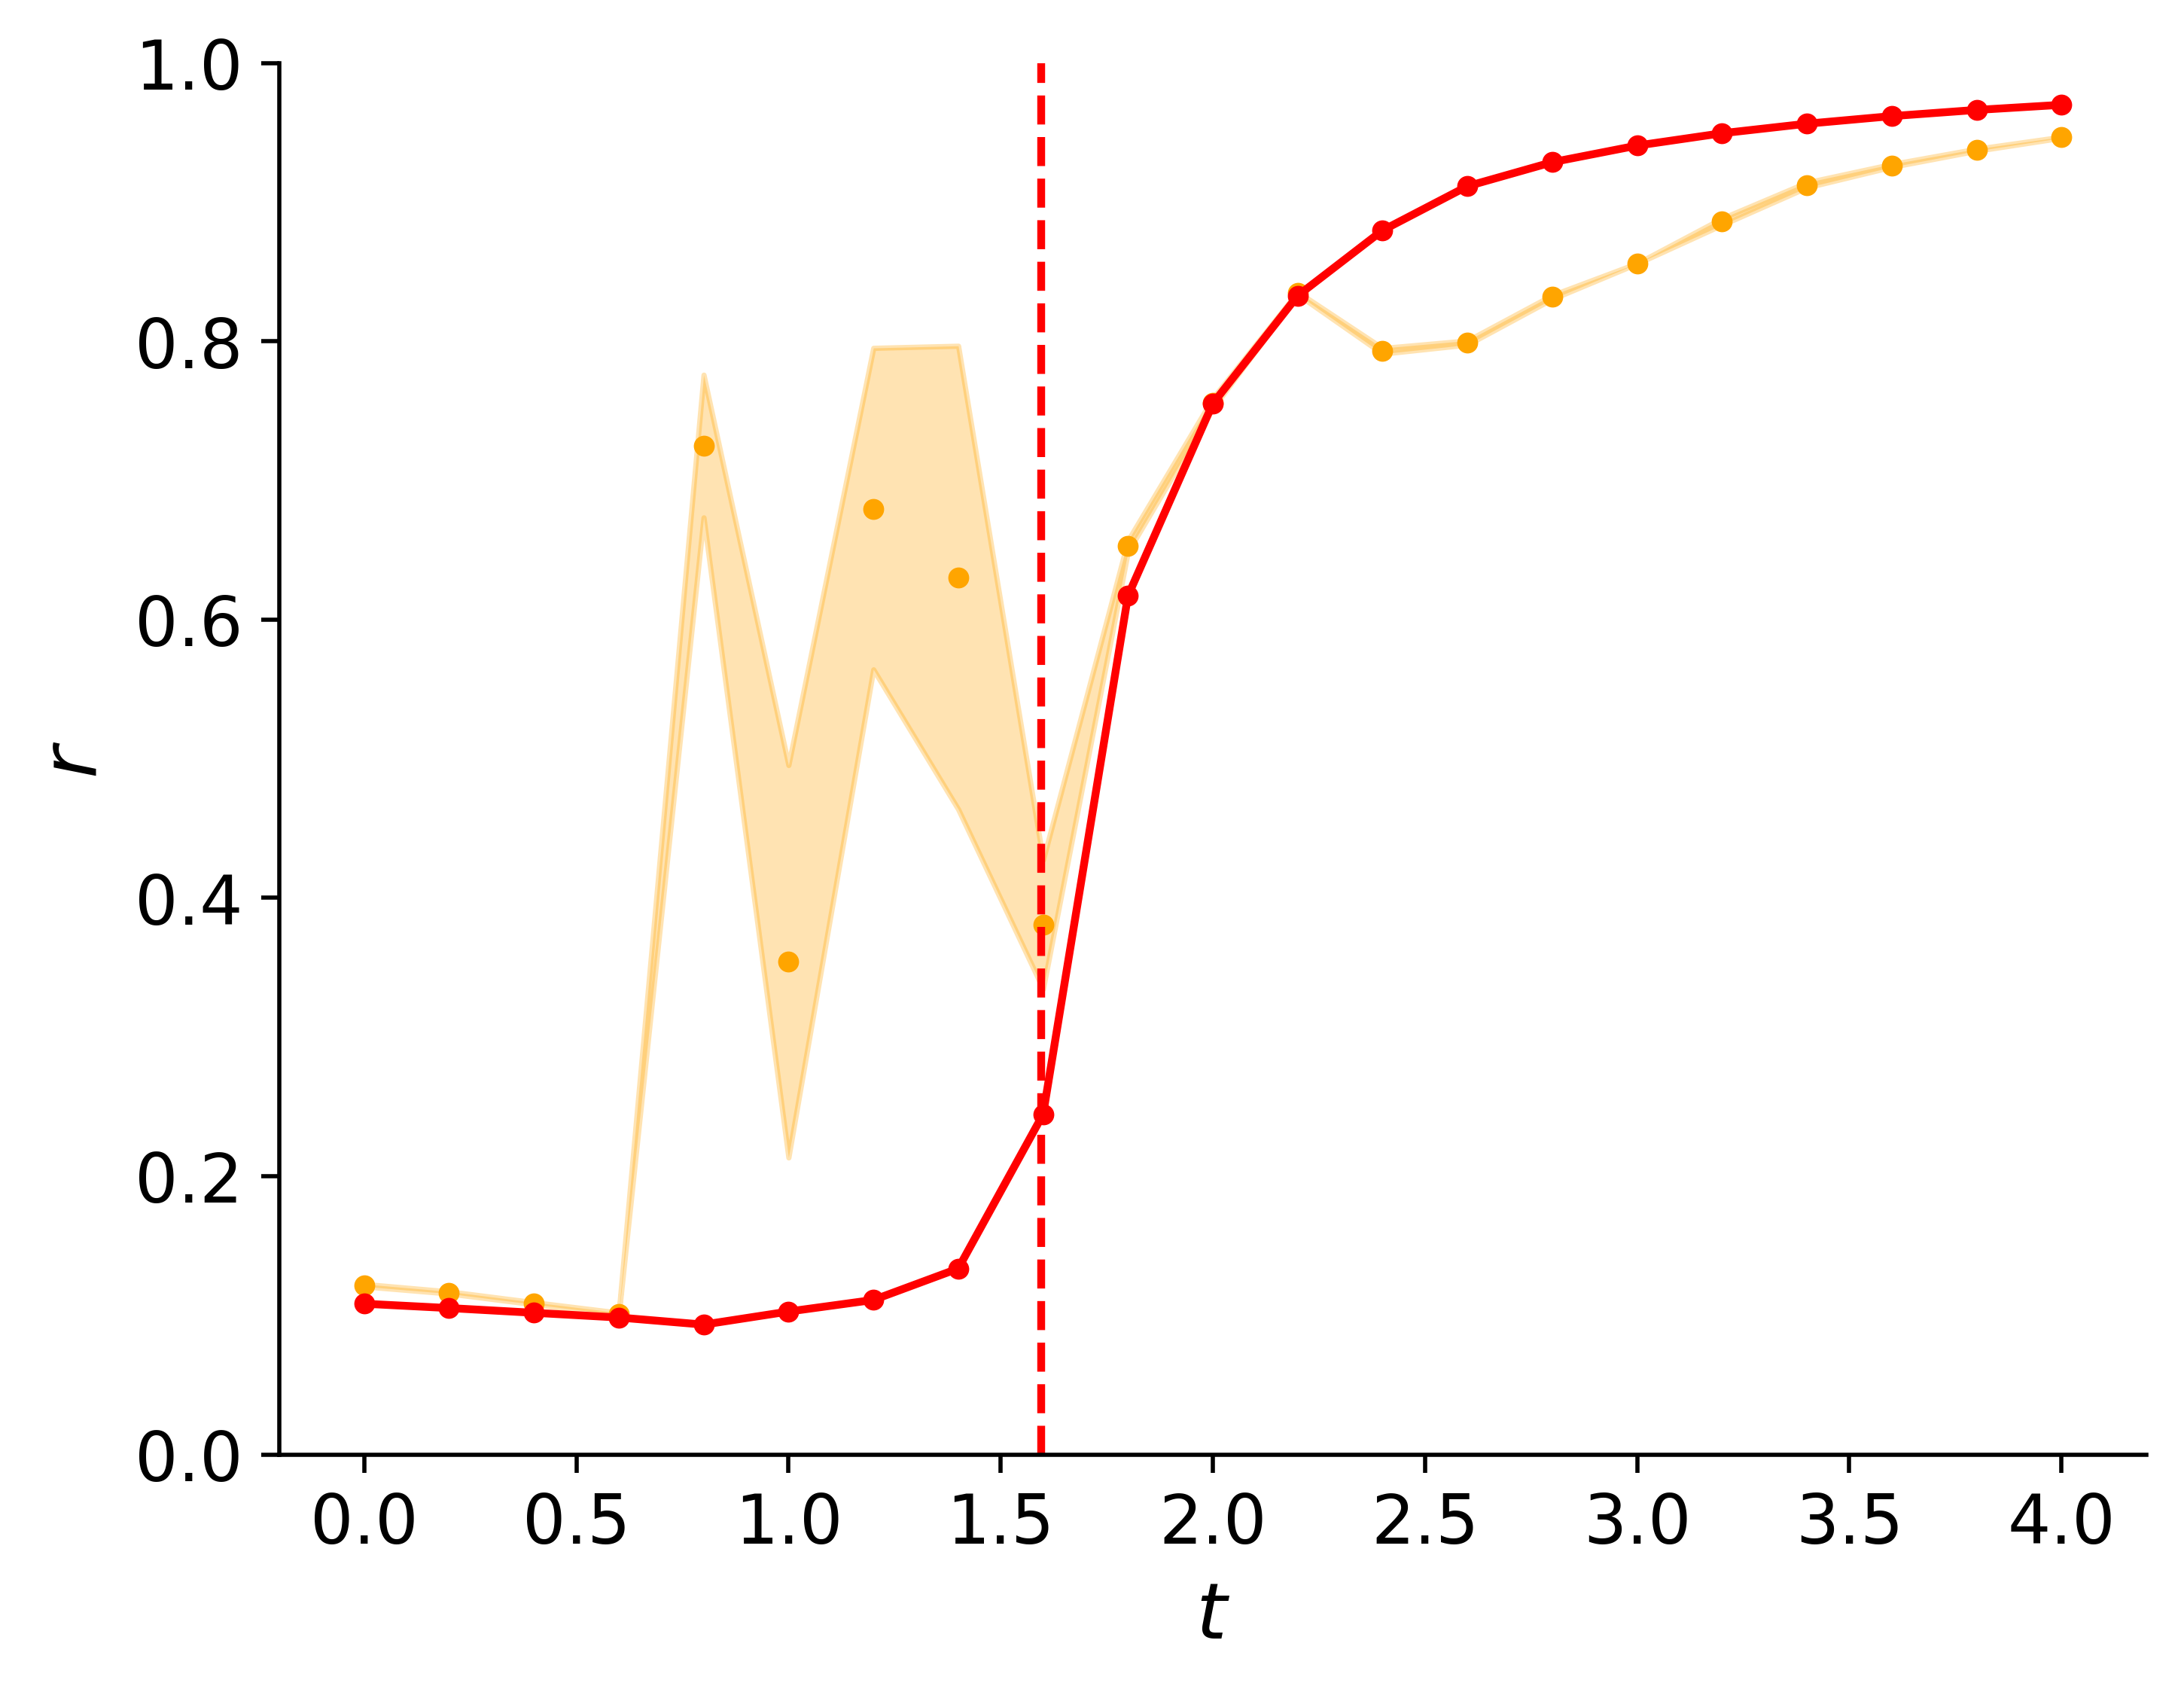

In [2271]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='Orange')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='Orange')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [2273]:
df_EKF = df

# Unscented Kalman filter

In [2240]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 1.5

In [2241]:
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

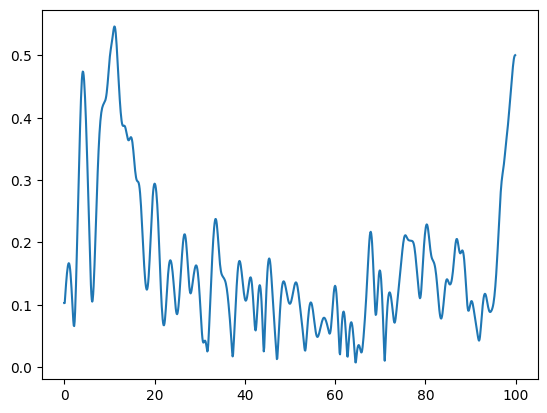

In [2242]:
plt.plot(t,rs)

In [2243]:
from numba import njit

In [2244]:
def f(x,omega=omega):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T)
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=0) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K]

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

In [2245]:

def sigma_points(x, P, lambda_):
    n = x.shape[0]
    chi = np.zeros((2*n+1,n))
    U = np.linalg.cholesky((n+lambda_)*P)
    chi[0] = x
    for i in range(n):
        chi[i+1] = x + U[i]
        chi[i+n+1] = x - U[i]
    return np.array(chi)  # shape: (2n+1, n)

def bar_sigma_points(chi):
    return np.array([f(sp,omega) for sp in chi])

In [2298]:
n = len(x)  # 상태벡터 차원
alpha = 0.5
beta = 4
kappa = -2
lambda_ = alpha**2*(n+kappa)-n
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02

Wm = np.full(2*n+1, 1/(2*(n+lambda_)))
Wc = np.full(2*n+1, 1/(2*(n+lambda_)))
Wm[0] = lambda_/(n+lambda_)
Wc[0] = lambda_/(n+lambda_) + (1 - alpha**2 + beta)
Wm/=np.sum(Wm)

In [2299]:
lambda_

-38.75

In [2300]:
x = np.r_[theta_random,K-1]

In [2301]:
chi = sigma_points(x, P, lambda_)
chi_bar = bar_sigma_points(chi)
x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
P_bar = np.zeros_like(P)
for i, cp in enumerate(chi_bar):
    diff = cp - x_bar
    P_bar += Wc[i] * np.outer(diff, diff)
P_bar += Q
# est

z_sigma = np.array([h(cp) for cp in chi_bar])
z_bar = np.sum(z_sigma.T * Wm, axis=1)

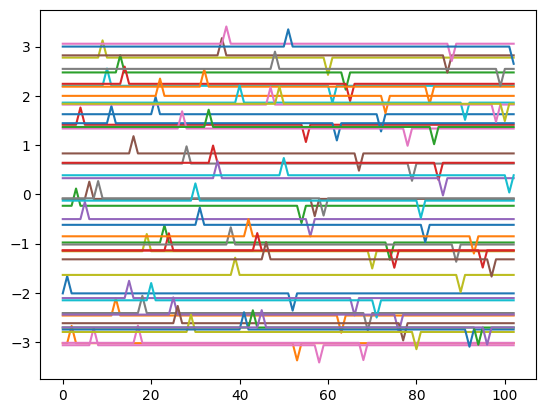

In [2302]:
plt.plot(chi);

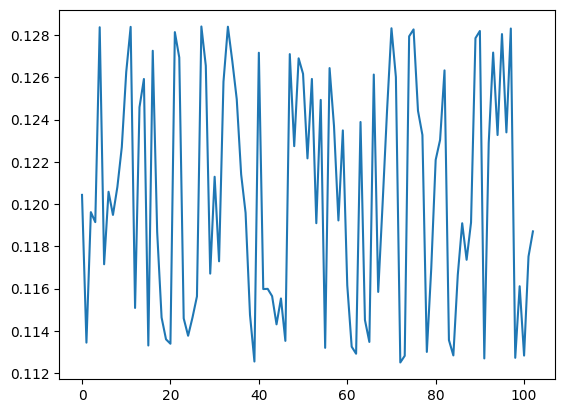

In [2303]:
plt.plot(z_sigma)

In [2304]:
print(z_bar,z_sigma[-1])

[0.1204047] [0.11870608]


In [2305]:
x = np.r_[theta_random,K-1]
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02
R_meas = 0.01

P_hats = np.zeros((len(t),*P.shape))
x_hats = np.zeros((len(t),len(x)))
z_hats = np.zeros((len(t)))
S_s = np.zeros((len(t)))
x_hats[0] = x
P_hats[0] = P
z_hats[0] = h(x)[0]



for num in range(1,len(t)):
    # pred
    chi = sigma_points(x, P, lambda_)
    chi_bar = bar_sigma_points(chi)
    x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
    P_bar = np.zeros_like(P)
    for i, cp in enumerate(chi_bar):
        diff = cp - x_bar
        P_bar += Wc[i] * np.outer(diff, diff)
    P_bar += Q
    # est

    z_sigma = np.array([h(cp) for cp in chi_bar])
    z_bar = np.sum(z_sigma.T * Wm, axis=1)

    S = np.zeros((len(z_bar), len(z_bar)))
    for i, zsp in enumerate(z_sigma):
        diff = zsp - z_bar
        S += Wc[i]*np.outer(diff, diff)
    S += R_meas  # 측정 노이즈 공분산 추가
    Pxz = np.zeros((n, len(z_bar)))
    for i, cp in enumerate(chi_bar):
        diff_x = (cp - x_bar).reshape(-1,1)
        diff_z = (z_sigma[i] - z_bar).reshape(-1,1)
        Pxz += Wc[i]*diff_x@diff_z.T
    K_gain = Pxz@np.linalg.inv(S)

    z_meas = rs[num] + np.random.rand()*R_meas
    x = x_bar + K_gain@(z_meas - z_bar)
    P = P_bar - K_gain@S@K_gain.T
    x_hats[num] = x
    P_hats[num] = P
    z_hats[num] = z_bar[0]
    print(z_bar,x[-1])


[0.1204047] 2.999943770049463
[0.1215693] 3.0001616332658814
[0.09883375] 3.0037380275665164
[0.08953185] 3.0138666023467446
[0.06713512] 3.0294341685168593
[0.05647283] 3.032888858267716
[0.08852263] 2.97661534087179
[0.1037747] 2.928596701142842
[0.16387311] 2.907463817457258
[0.217624] 2.9198444844105547
[0.25311667] 2.948363319337885
[0.42955041] 2.959092966307368
[0.44427887] 2.9788343861166466
[0.44963028] 3.007998254026996
[0.50052762] 3.044245156901235
[0.51120756] 3.07192375294903
[0.51375474] 3.11167256279417
[0.69651213] 3.134312152276226
[0.75204309] 3.150314749665818
[0.78688253] 3.1633264395737597
[0.82328315] 3.172301233443842
[0.84681483] 3.1783256881199966
[0.85981618] 3.18260195284503
[0.8732155] 3.185478827088994
[0.89370111] 3.1882036198435637
[0.91314011] 3.1903697141554903
[0.92418361] 3.1920278428329643
[0.93010921] 3.1932766401771744
[0.9336231] 3.1943755755010548
[0.9356444] 3.1956910992643395
[0.93679857] 3.196949029757346
[0.93788016] 3.1980761658116954
[0.93

In [2254]:
np.mean(x_hats[-50:,-1]) - K,np.mean(x_hats_KM[-50:,-1]) - K

(-5.59295995343626, 1.6437830577978478)

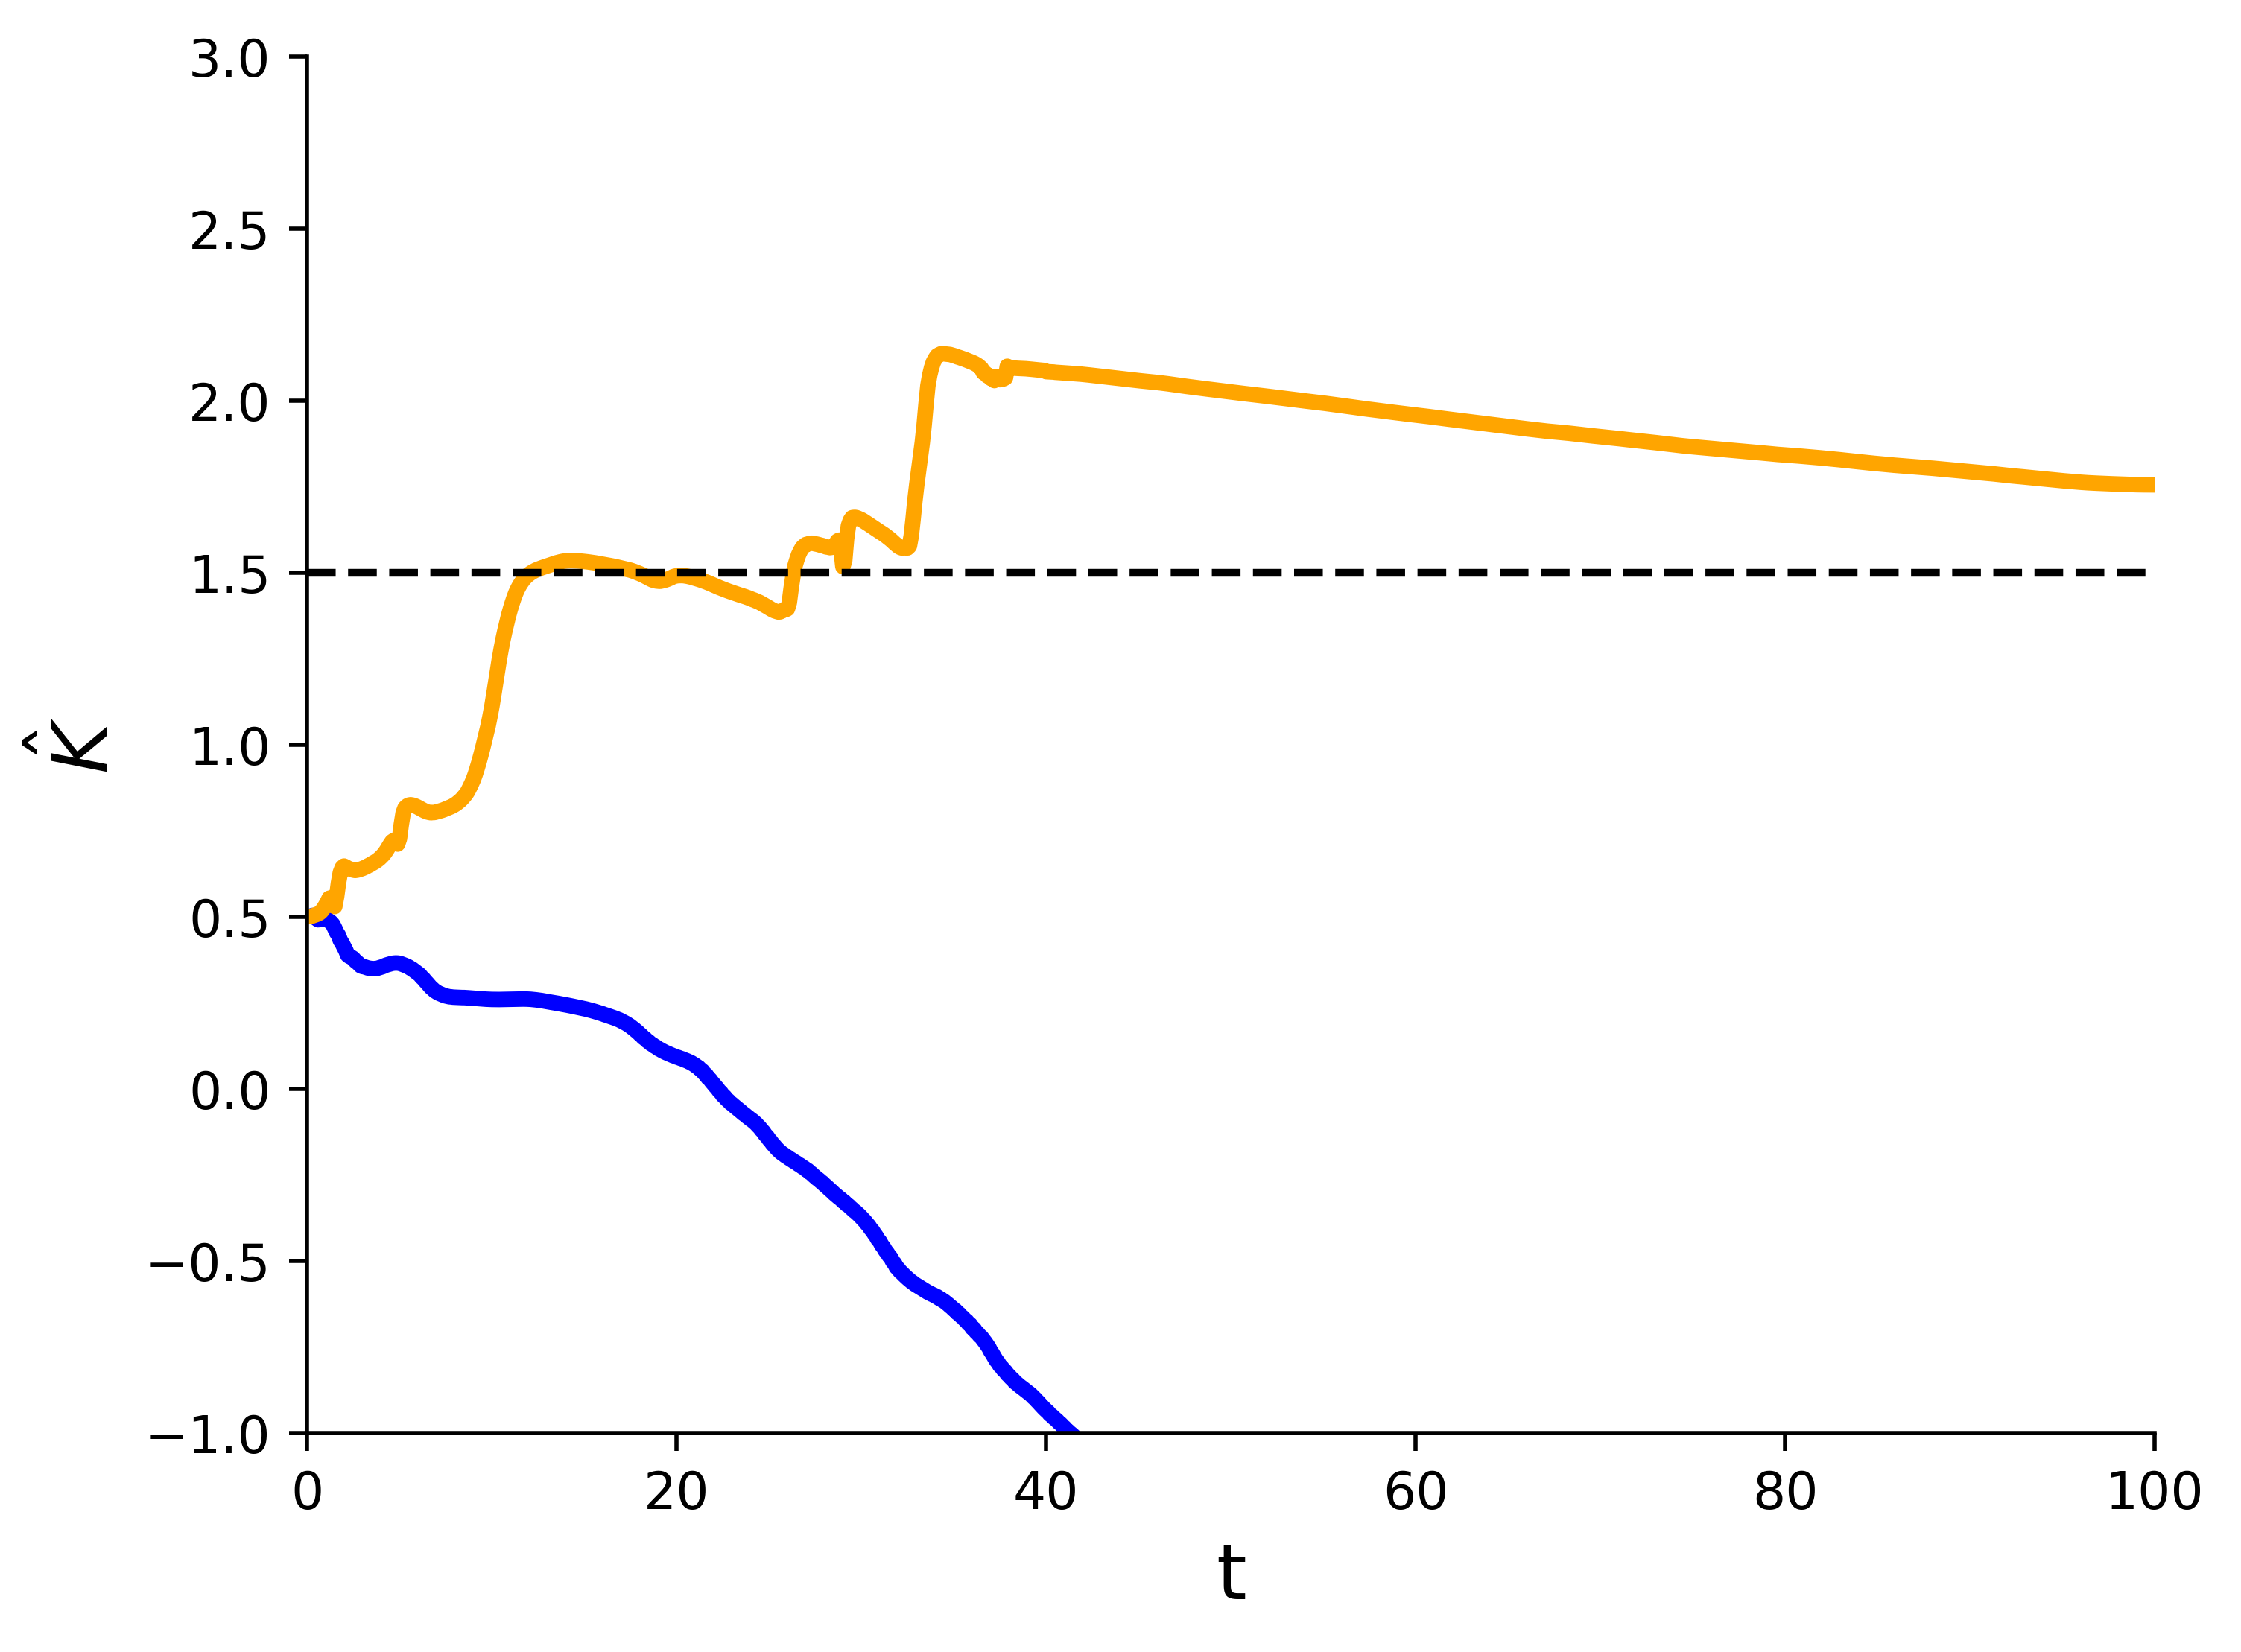

In [2259]:
plt.figure(dpi=500)
plt.plot(t,x_hats[:,-1],color='blue',lw=3)
plt.plot(t,x_hats_KM[:,-1],color='orange',lw=3)
plt.axhline(K,color='black',ls='--')
plt.ylim(-1,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

(0.0, 1.0)

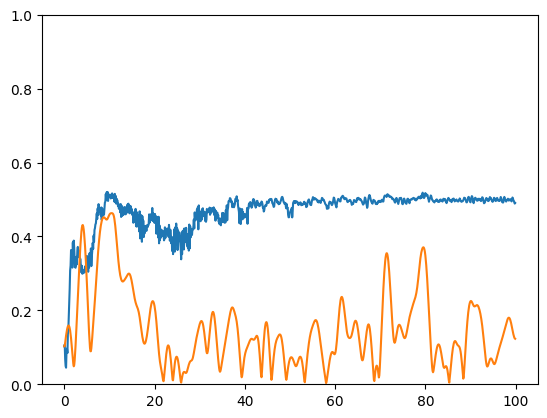

In [2239]:
plt.plot(t,z_hats)
plt.plot(t,rs)
plt.ylim(0,1)

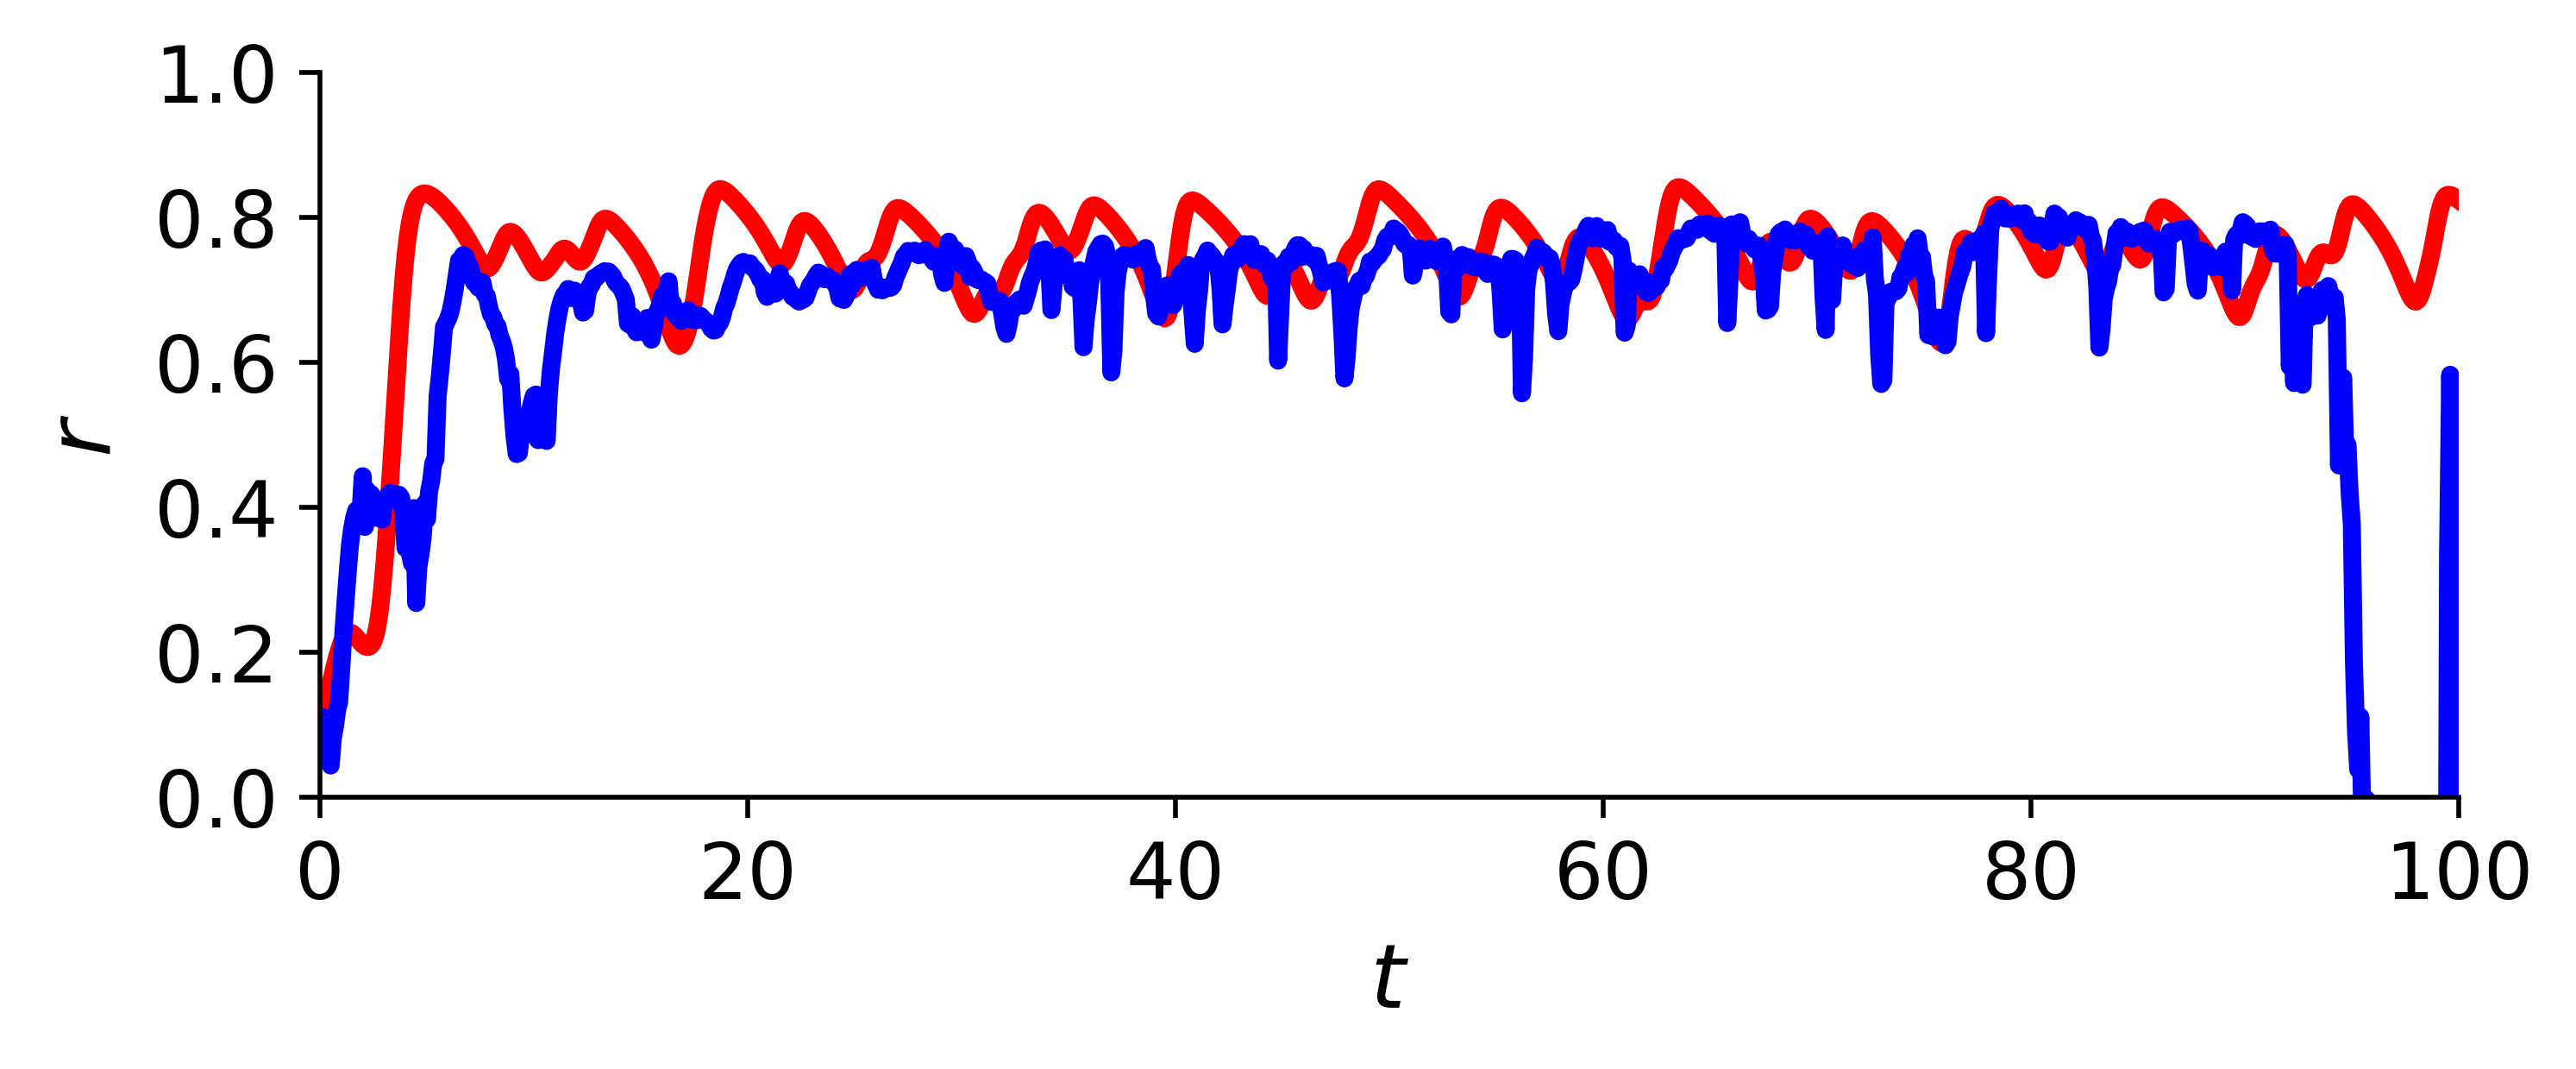

In [1742]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_hats,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)




# plt.plot(t,rs)

In [2306]:
alpha = 0.5
beta = 3
kappa = -2
lambda_ = alpha**2*(n+kappa)-n
Q = np.eye(N+1)*0
P = np.eye(N+1)*0.01
Q[-1,-1] = 0.02

Wm = np.full(2*n+1, 1/(2*(n+lambda_)))
Wc = np.full(2*n+1, 1/(2*(n+lambda_)))
Wm[0] = lambda_/(n+lambda_)
Wc[0] = lambda_/(n+lambda_) + (1 - alpha**2 + beta)
Wm/=np.sum(Wm)

In [2307]:
K_rs = []
K_est_UKF = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est_UKF['r',K] = []
    K_est_UKF['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num):
        x = np.r_[theta_random,K-1]
        Q = np.eye(N+1)*0
        P = np.eye(N+1)*0.01
        Q[-1,-1] = 0.02
        R_meas = 0.01

        P_hats = np.zeros((len(t),*P.shape))
        x_hats = np.zeros((len(t),len(x)))
        z_hats = np.zeros((len(t)))
        S_s = np.zeros((len(t)))
        x_hats[0] = x
        P_hats[0] = P
        z_hats[0] = h(x)[0]
        for num in range(1,len(t)):
            # pred
            try:
                chi = sigma_points(x, P, lambda_)
            except:
                break
            chi_bar = bar_sigma_points(chi)
            x_bar = np.sum(chi_bar.T * Wm, axis=1)  # (n,)
            P_bar = np.zeros_like(P)
            for i, cp in enumerate(chi_bar):
                diff = cp - x_bar
                P_bar += Wc[i] * np.outer(diff, diff)
            P_bar += Q
            # est

            z_sigma = np.array([h(cp) for cp in chi_bar])
            z_bar = np.sum(z_sigma.T * Wm, axis=1)

            S = np.zeros((len(z_bar), len(z_bar)))
            for i, zsp in enumerate(z_sigma):
                diff = zsp - z_bar
                S += Wc[i]*np.outer(diff, diff)
            S += R_meas  # 측정 노이즈 공분산 추가
            Pxz = np.zeros((n, len(z_bar)))
            for i, cp in enumerate(chi_bar):
                diff_x = (cp - x_bar).reshape(-1,1)
                diff_z = (z_sigma[i] - z_bar).reshape(-1,1)
                Pxz += Wc[i]*diff_x@diff_z.T
            K_gain = Pxz@np.linalg.inv(S)

            z_meas = rs[num] + np.random.rand()*R_meas
            x = x_bar + K_gain@(z_meas - z_bar)
            P = P_bar - K_gain@S@K_gain.T
            x_hats[num] = x
            P_hats[num] = P
            z_hats[num] = z_bar[0]


        K_est_UKFm = np.mean(x_hats[-500:,-1]) 
        r_estm = np.mean(z_hats[-500:]) 
        return K_est_UKFm,r_estm
    K_est_UKFs,r_ests = zip(*get_r_K_mean)
    K_est_UKF['K',K] = K_est_UKFs
    K_est_UKF['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

In [2308]:
df_UKF = pd.DataFrame(K_est_UKF)

In [2311]:
df = df_UKF.copy()

In [2312]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

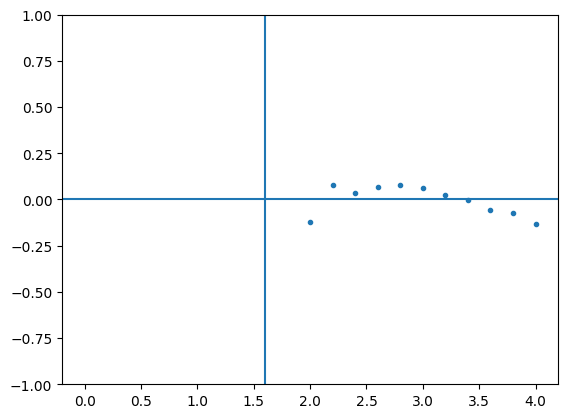

In [2321]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
plt.ylim(-1,1)
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)

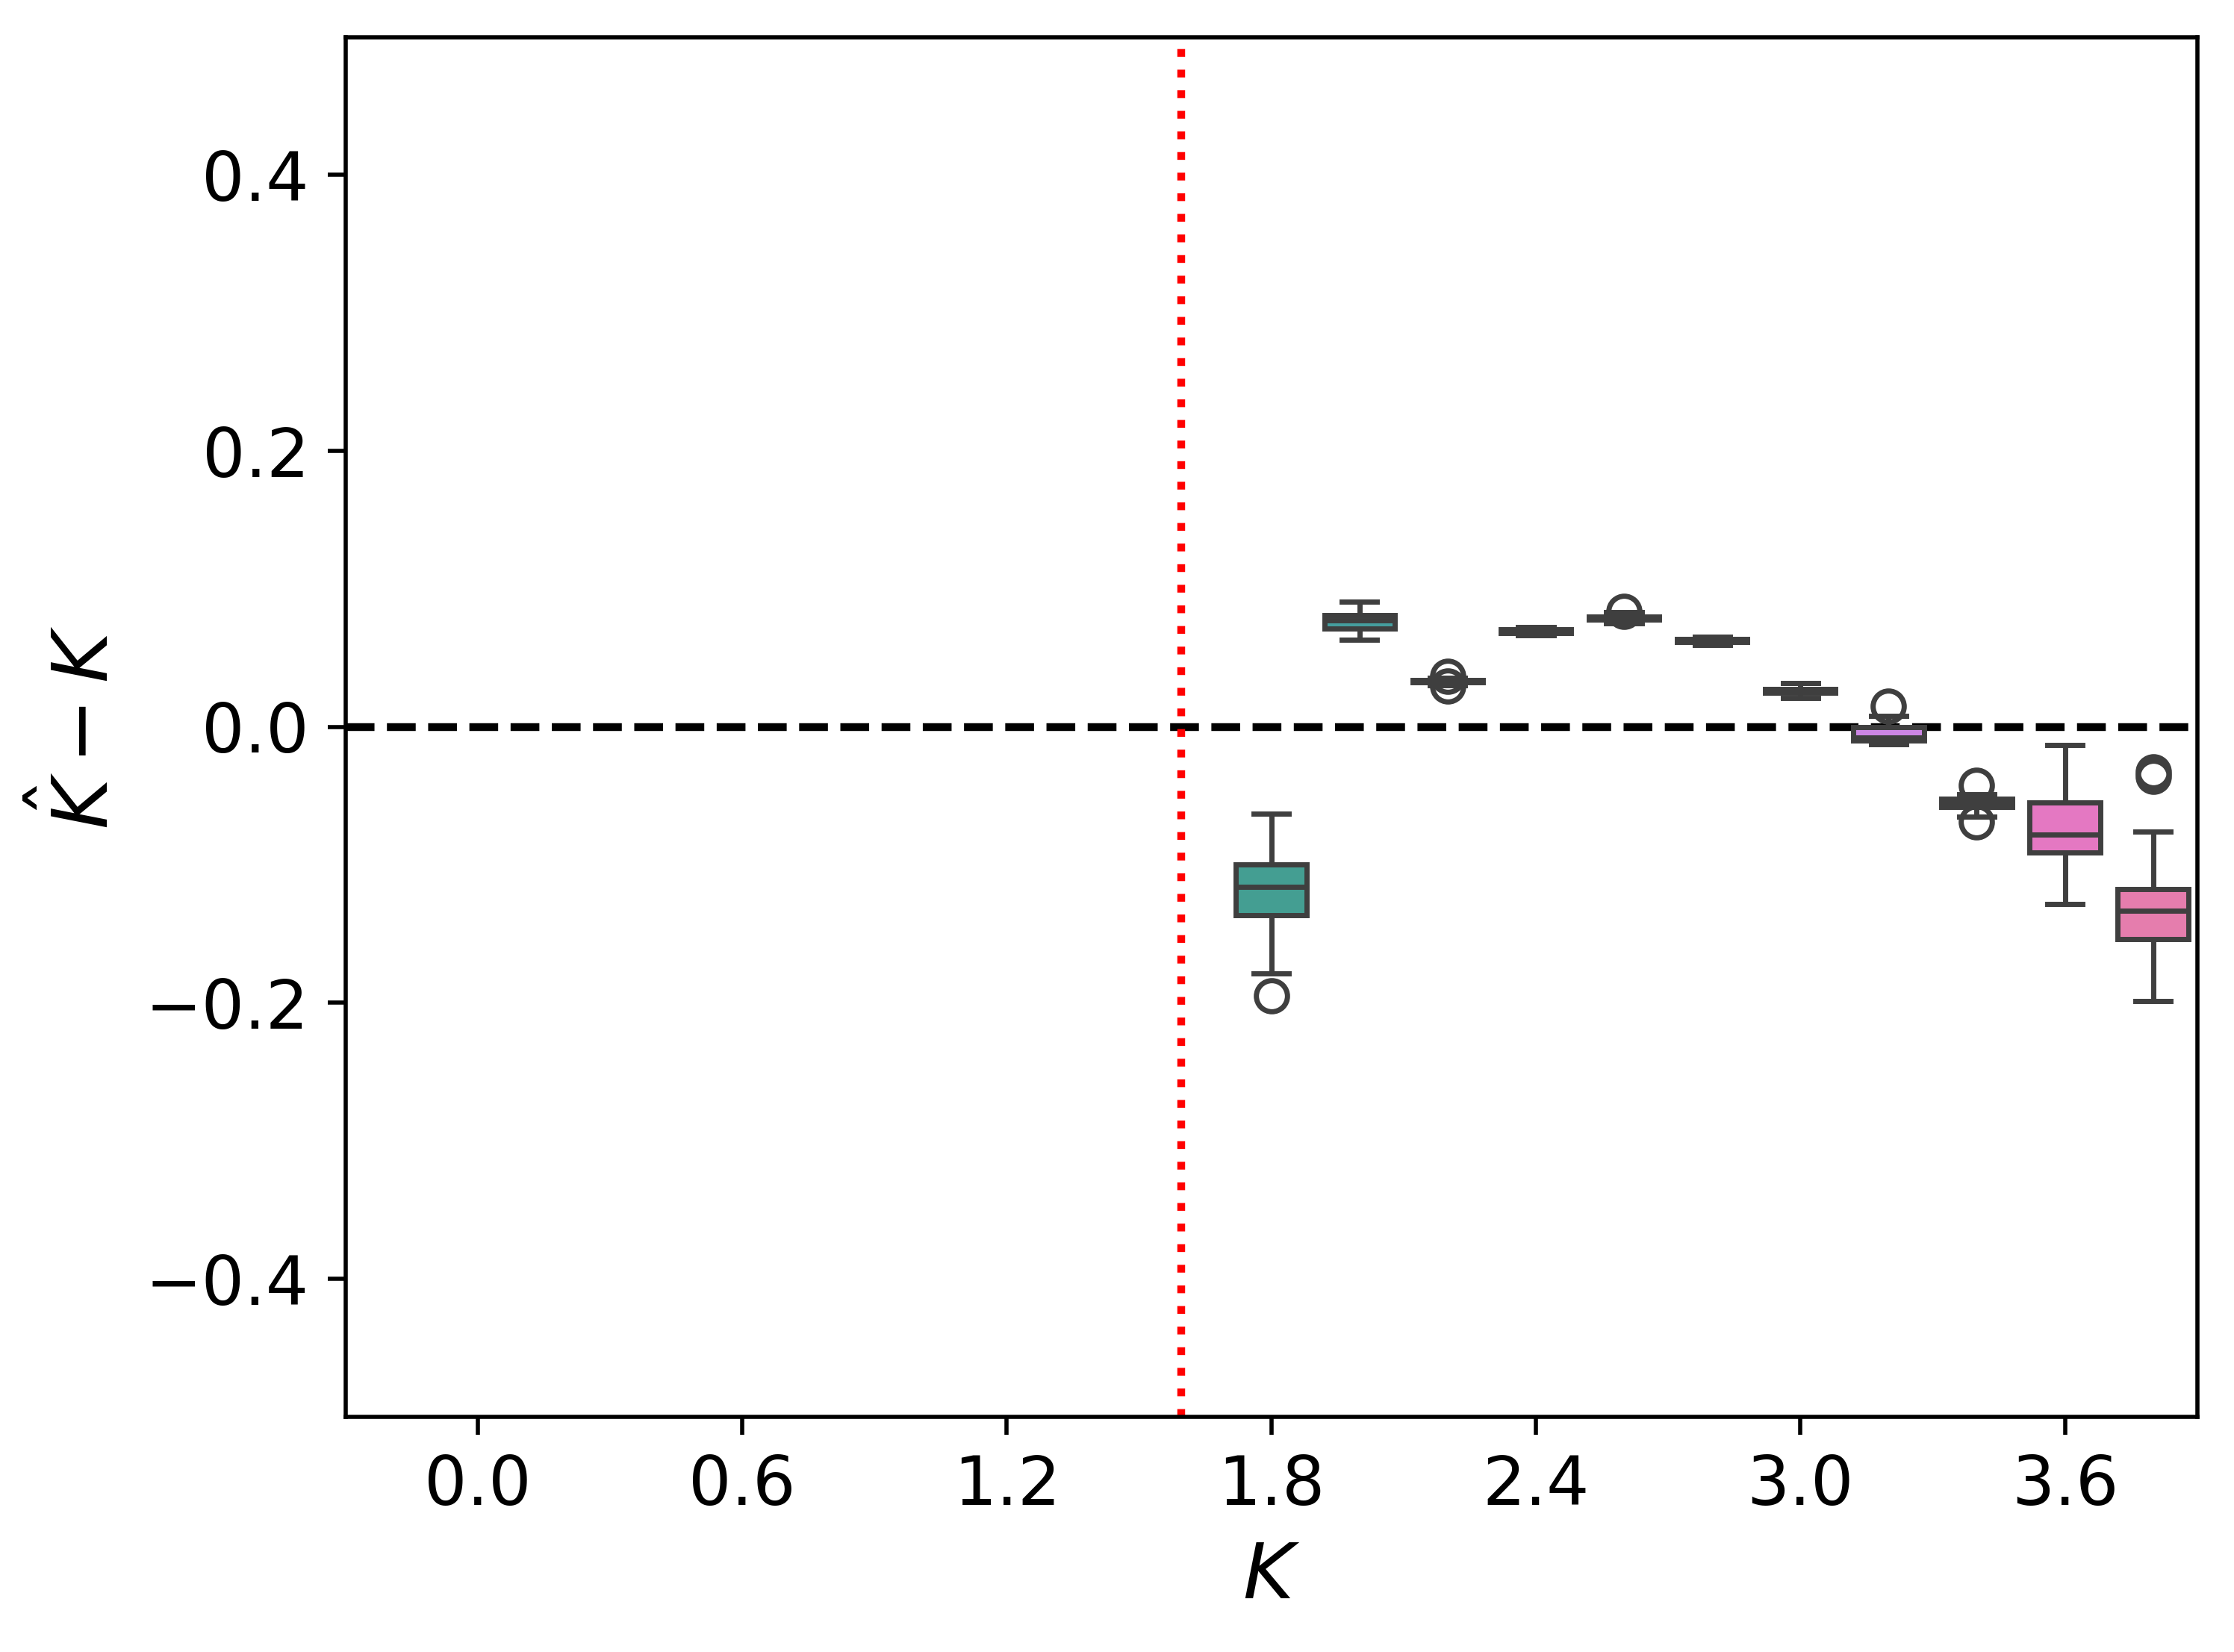

In [2323]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.2+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
plt.ylim(-0.5,0.5)
# plt.title('Box plot of KK - Ks')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

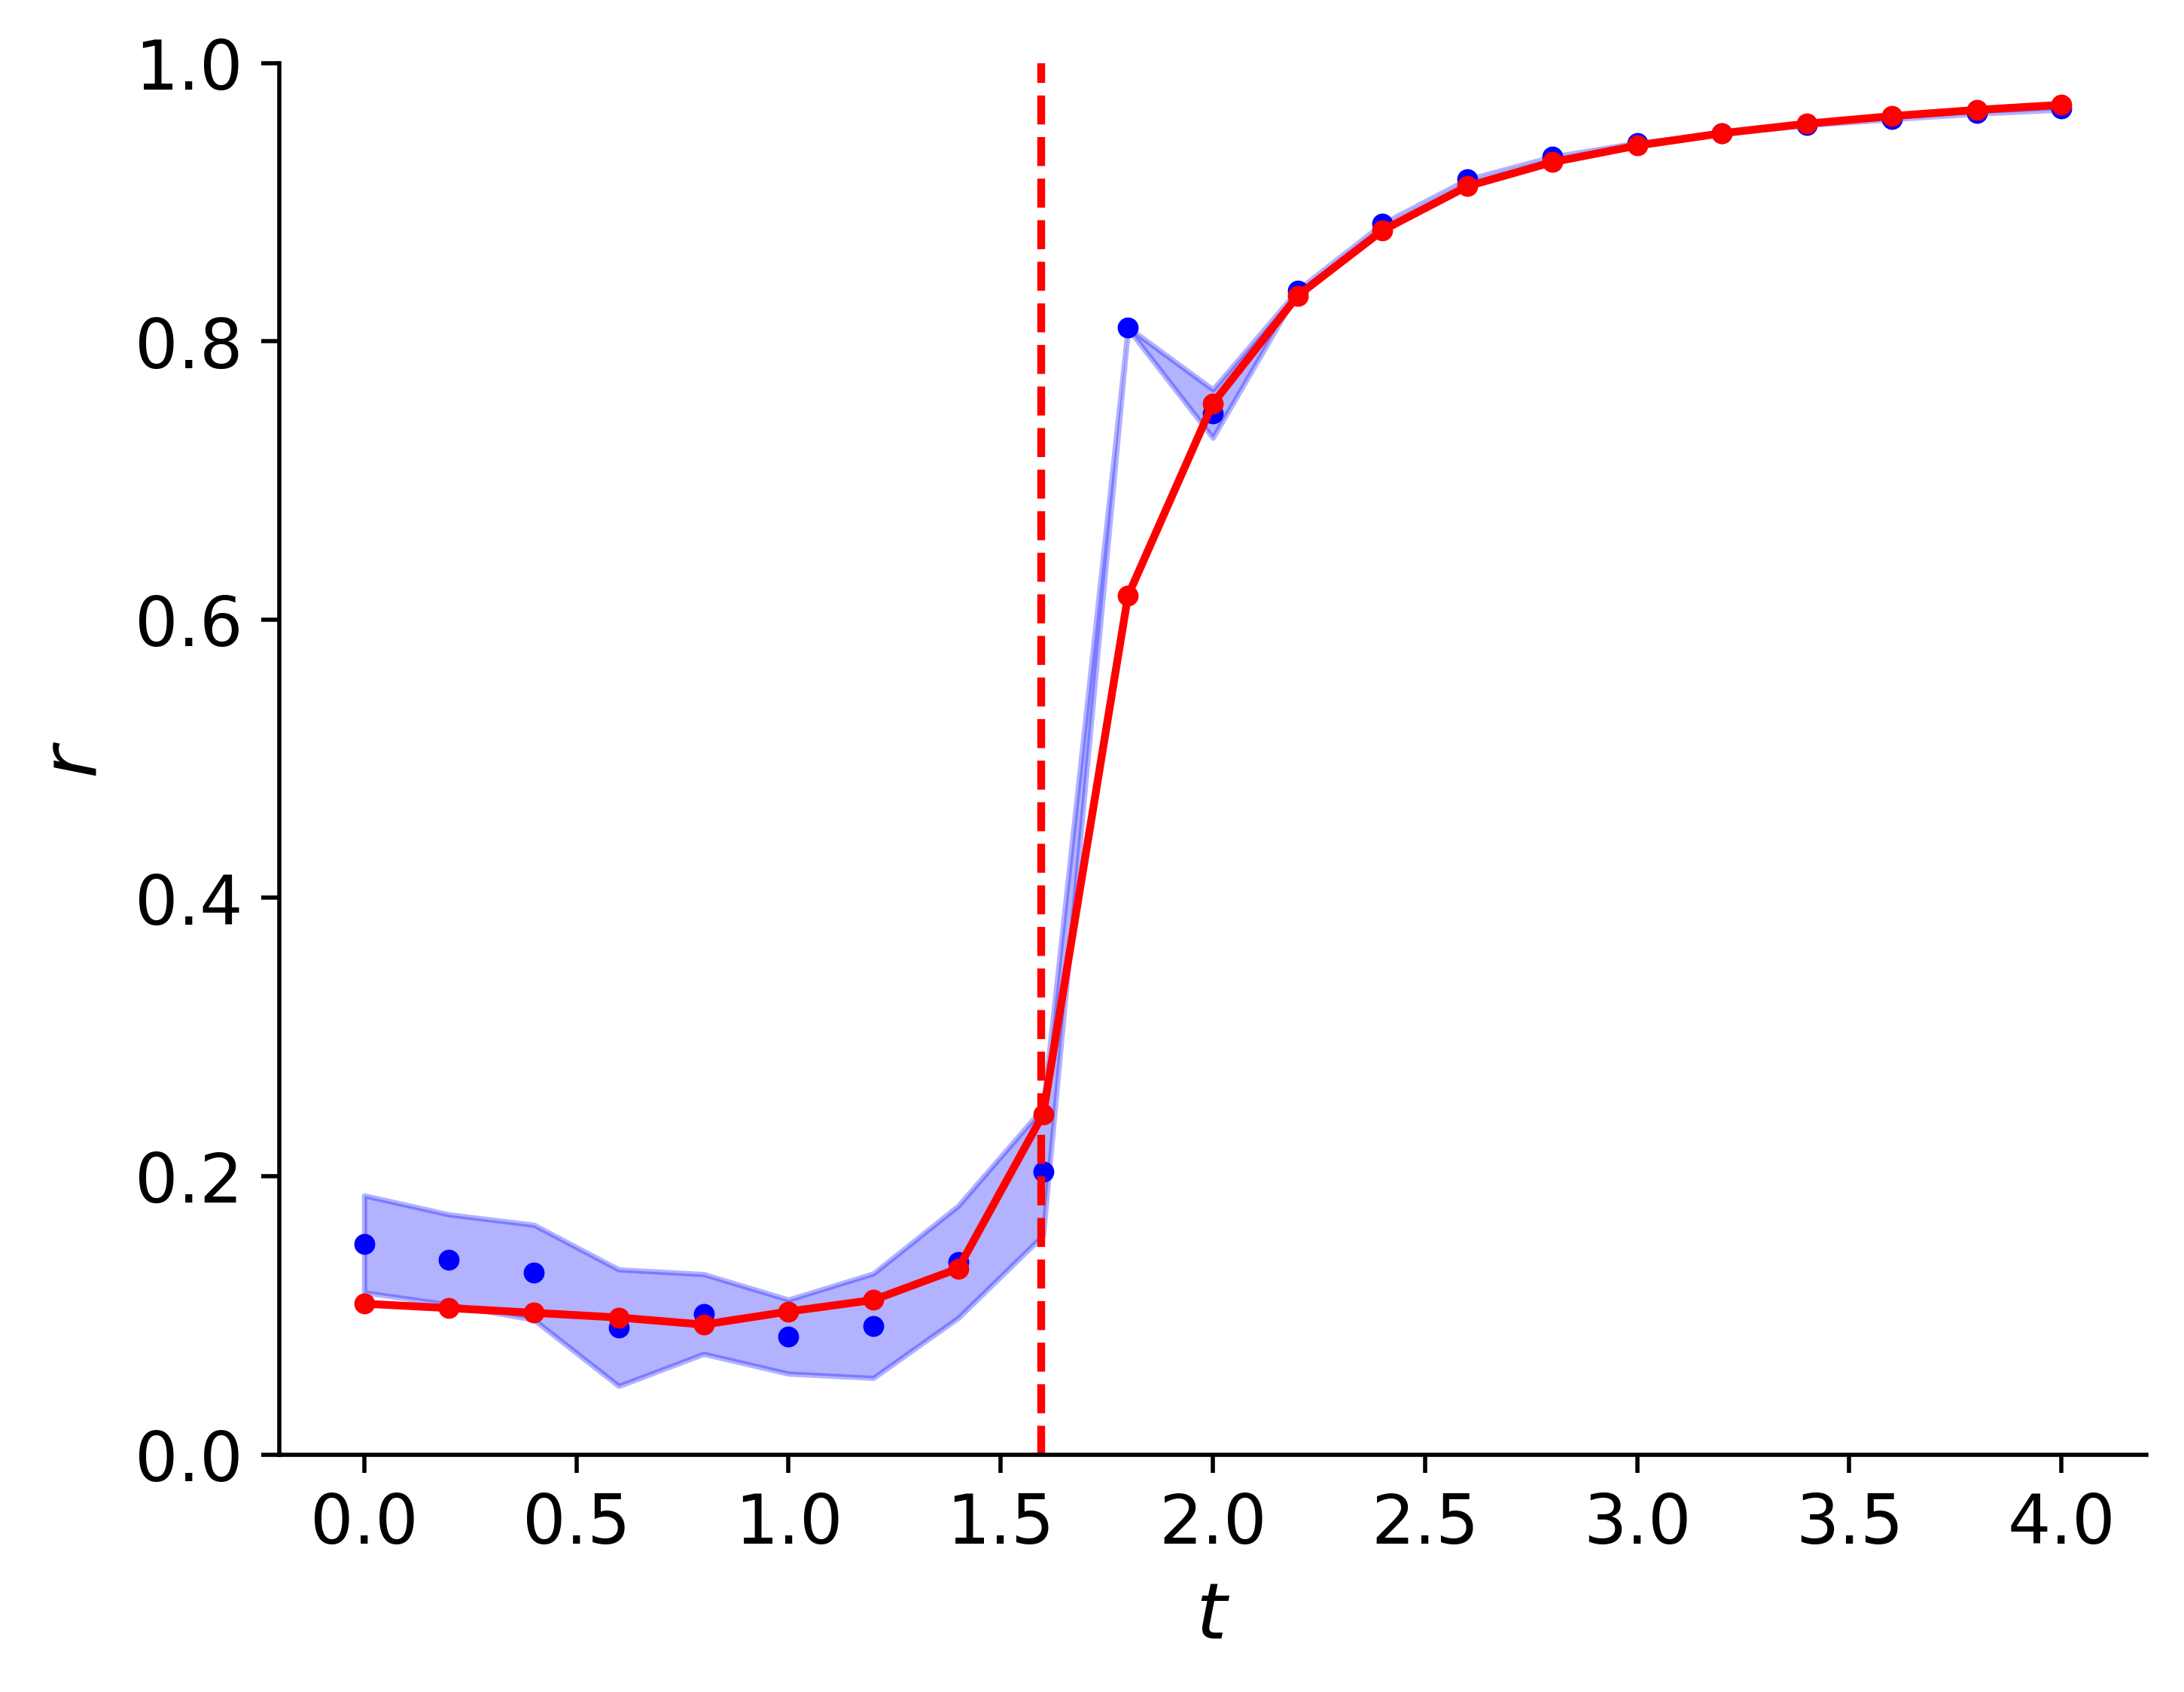

In [2325]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='Blue')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='Blue')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Particle filter

In [2333]:
from numba import njit

In [2543]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 2
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [2545]:
def f(x,omega=omega,K_noise=0):
    x = x.copy()
    T = x[:N]
    K = x[-1]
    Ti,Tj = np.meshgrid(T,T)
    dtheta = omega + K/N*np.sum(np.sin(Tj - Ti),axis=0) 
    T_new = T + dtheta*dt
    T_new = (T_new+np.pi)%(2*np.pi) -  np.pi
    return np.r_[T_new,K+np.random.randn()*K_noise]

def h(x):
    x = x.copy()
    T = x[:N]
    R = np.abs(np.mean(np.exp(1j*T)))
    return np.array([R])

In [2546]:
def predict_p(particles,omega,N_p):
    p = particles.copy()
    for i in range(N_p):
        p[i] = f(p[i],omega)
    return p

def meas_p(p_bar):
    return np.array([h(p) for p in p_bar])
def likelihood(z, R_pred,R_meas):
    return np.exp(-0.5*(z - R_pred)**2 / R_meas) / np.sqrt(2*np.pi*R_meas)

In [2537]:
N_p = 200
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
weights = np.ones(N_p)/N_p
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

for i in range(N_p):
    particles[i] = f(particles[i])

for i in range(N_p):
    R_pred = h(particles[i])
    w = likelihood(rs[num] + np.random.randn()*np.sqrt(R_meas),R_pred,R_meas)
    weights[i]*=w
weights += 1e-300
weights/=np.sum(weights)
x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
particles[:,:N] = (particles[:,:N]+np.pi)%(2*np.pi) - np.pi
z_hat = h(x_hat)

IndexError: index 1999 is out of bounds for axis 0 with size 1000

In [2500]:
x_hat

array([-1.48205895, -0.73736594, -2.70228411,  1.88332804,  0.04387377,
        1.01488003, -1.13152722,  1.53908817,  1.12709349, -0.35329731,
        1.13967402,  0.89303162, -0.70814747,  0.42579744, -1.72596067,
        1.84658143,  0.92696706,  0.31166784,  0.23196836,  1.73142777,
        1.28359381, -1.95086639, -2.05614531,  0.16307809,  0.93165958,
       -1.09992134, -0.55309103,  1.53121773,  0.77797847, -0.50109642,
        0.82649276,  1.19285099, -2.79495944,  1.4439775 ,  0.67271472,
        0.78058814, -2.22196717,  0.056315  ,  1.72969979,  1.28022717,
        1.04156233,  0.61973009, -2.28310827, -1.33202513,  2.24969367,
        0.64305376, -2.60977051, -0.88025103,  0.19433123, -0.55714663,
        1.54623432])

In [2761]:
T_s = {}

In [2781]:
import time

N_p = 12800
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

weights = np.ones(N_p)/N_p
P_arr = np.zeros((len(t),*particles.shape))
X_arr = np.zeros((len(t),N+1))

z_arr = np.zeros((len(t)))
W_arr = np.zeros((len(t),*weights.shape))
Neff_arr = np.zeros(len(t))
T_s[N_p] = []
for num in range(len(t)):
    
    start_time = time.time()

    for i in range(N_p):
        particles[i] = f(particles[i], K_noise=0.005)

    for i in range(N_p):
        R_pred = h(particles[i])
        w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
        weights[i] *= w
    weights += 1e-30
    weights /= np.sum(weights)
    particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

    x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
    z_hat = h(x_hat)
    ESS = 1.0 / np.sum(weights**2)
    X_arr[num] = x_hat
    z_arr[num] = z_hat[0]
    P_arr[num] = particles
    W_arr[num] = weights
    if ESS < N_p * 0.7:
        indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
        particles = particles[indices]
        weights = np.ones(N_p) / N_p

    end_time = time.time()
    T_ = end_time - start_time
    T_s[N_p].append(T_)
    if num == 100:
        break
    print(f"ESS: {ESS}, z_hat: {z_hat[0]}, x_hat[-1]: {x_hat[-1]}, Time taken: {end_time - start_time} seconds")

# for i in range(N_p):
#     R_pred = f(particles[i],omega)

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_8937/2273439193.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] *= w


ESS: 10065.984751163045, z_hat: 0.9998143188775045, x_hat[-1]: 1.999693809687239, Time taken: 0.8492720127105713 seconds
ESS: 7876.327025908689, z_hat: 0.9998376197677259, x_hat[-1]: 1.9911780330800846, Time taken: 0.8520119190216064 seconds
ESS: 10230.977029348129, z_hat: 0.9996866353926015, x_hat[-1]: 1.9927725817639228, Time taken: 0.8509199619293213 seconds
ESS: 8112.805660521851, z_hat: 0.9996782408321713, x_hat[-1]: 1.9867516152459377, Time taken: 0.8578577041625977 seconds
ESS: 10303.952787180537, z_hat: 0.9994669045375215, x_hat[-1]: 1.9745873742428854, Time taken: 0.8460590839385986 seconds
ESS: 8265.199762320679, z_hat: 0.9993567537692849, x_hat[-1]: 1.9629581535630132, Time taken: 0.8569540977478027 seconds
ESS: 10301.952347944305, z_hat: 0.999381630072052, x_hat[-1]: 1.9595192617981267, Time taken: 0.8389608860015869 seconds
ESS: 8233.315207946105, z_hat: 0.9994293188520664, x_hat[-1]: 1.9568630317147562, Time taken: 0.864210844039917 seconds
ESS: 10179.585900197528, z_hat:

In [2806]:
y = np.poly1d(np.polyfit(xs.to_numpy(),df_T.mean().sort_index().to_numpy(),1))

In [2809]:
np.polyfit(xs.to_numpy(),df_T.mean().sort_index().to_numpy(),1)

array([6.12076938e-05, 1.55149704e-04])

In [2812]:
y(50) * 1000

3.2155343942327024

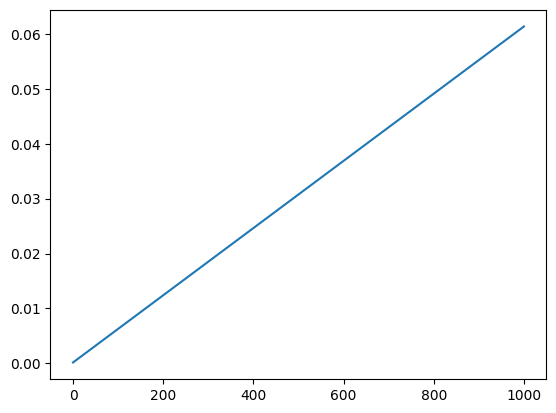

In [ ]:
ms = np.linspace(0,1000)
plt.plot(ms,y(ms))


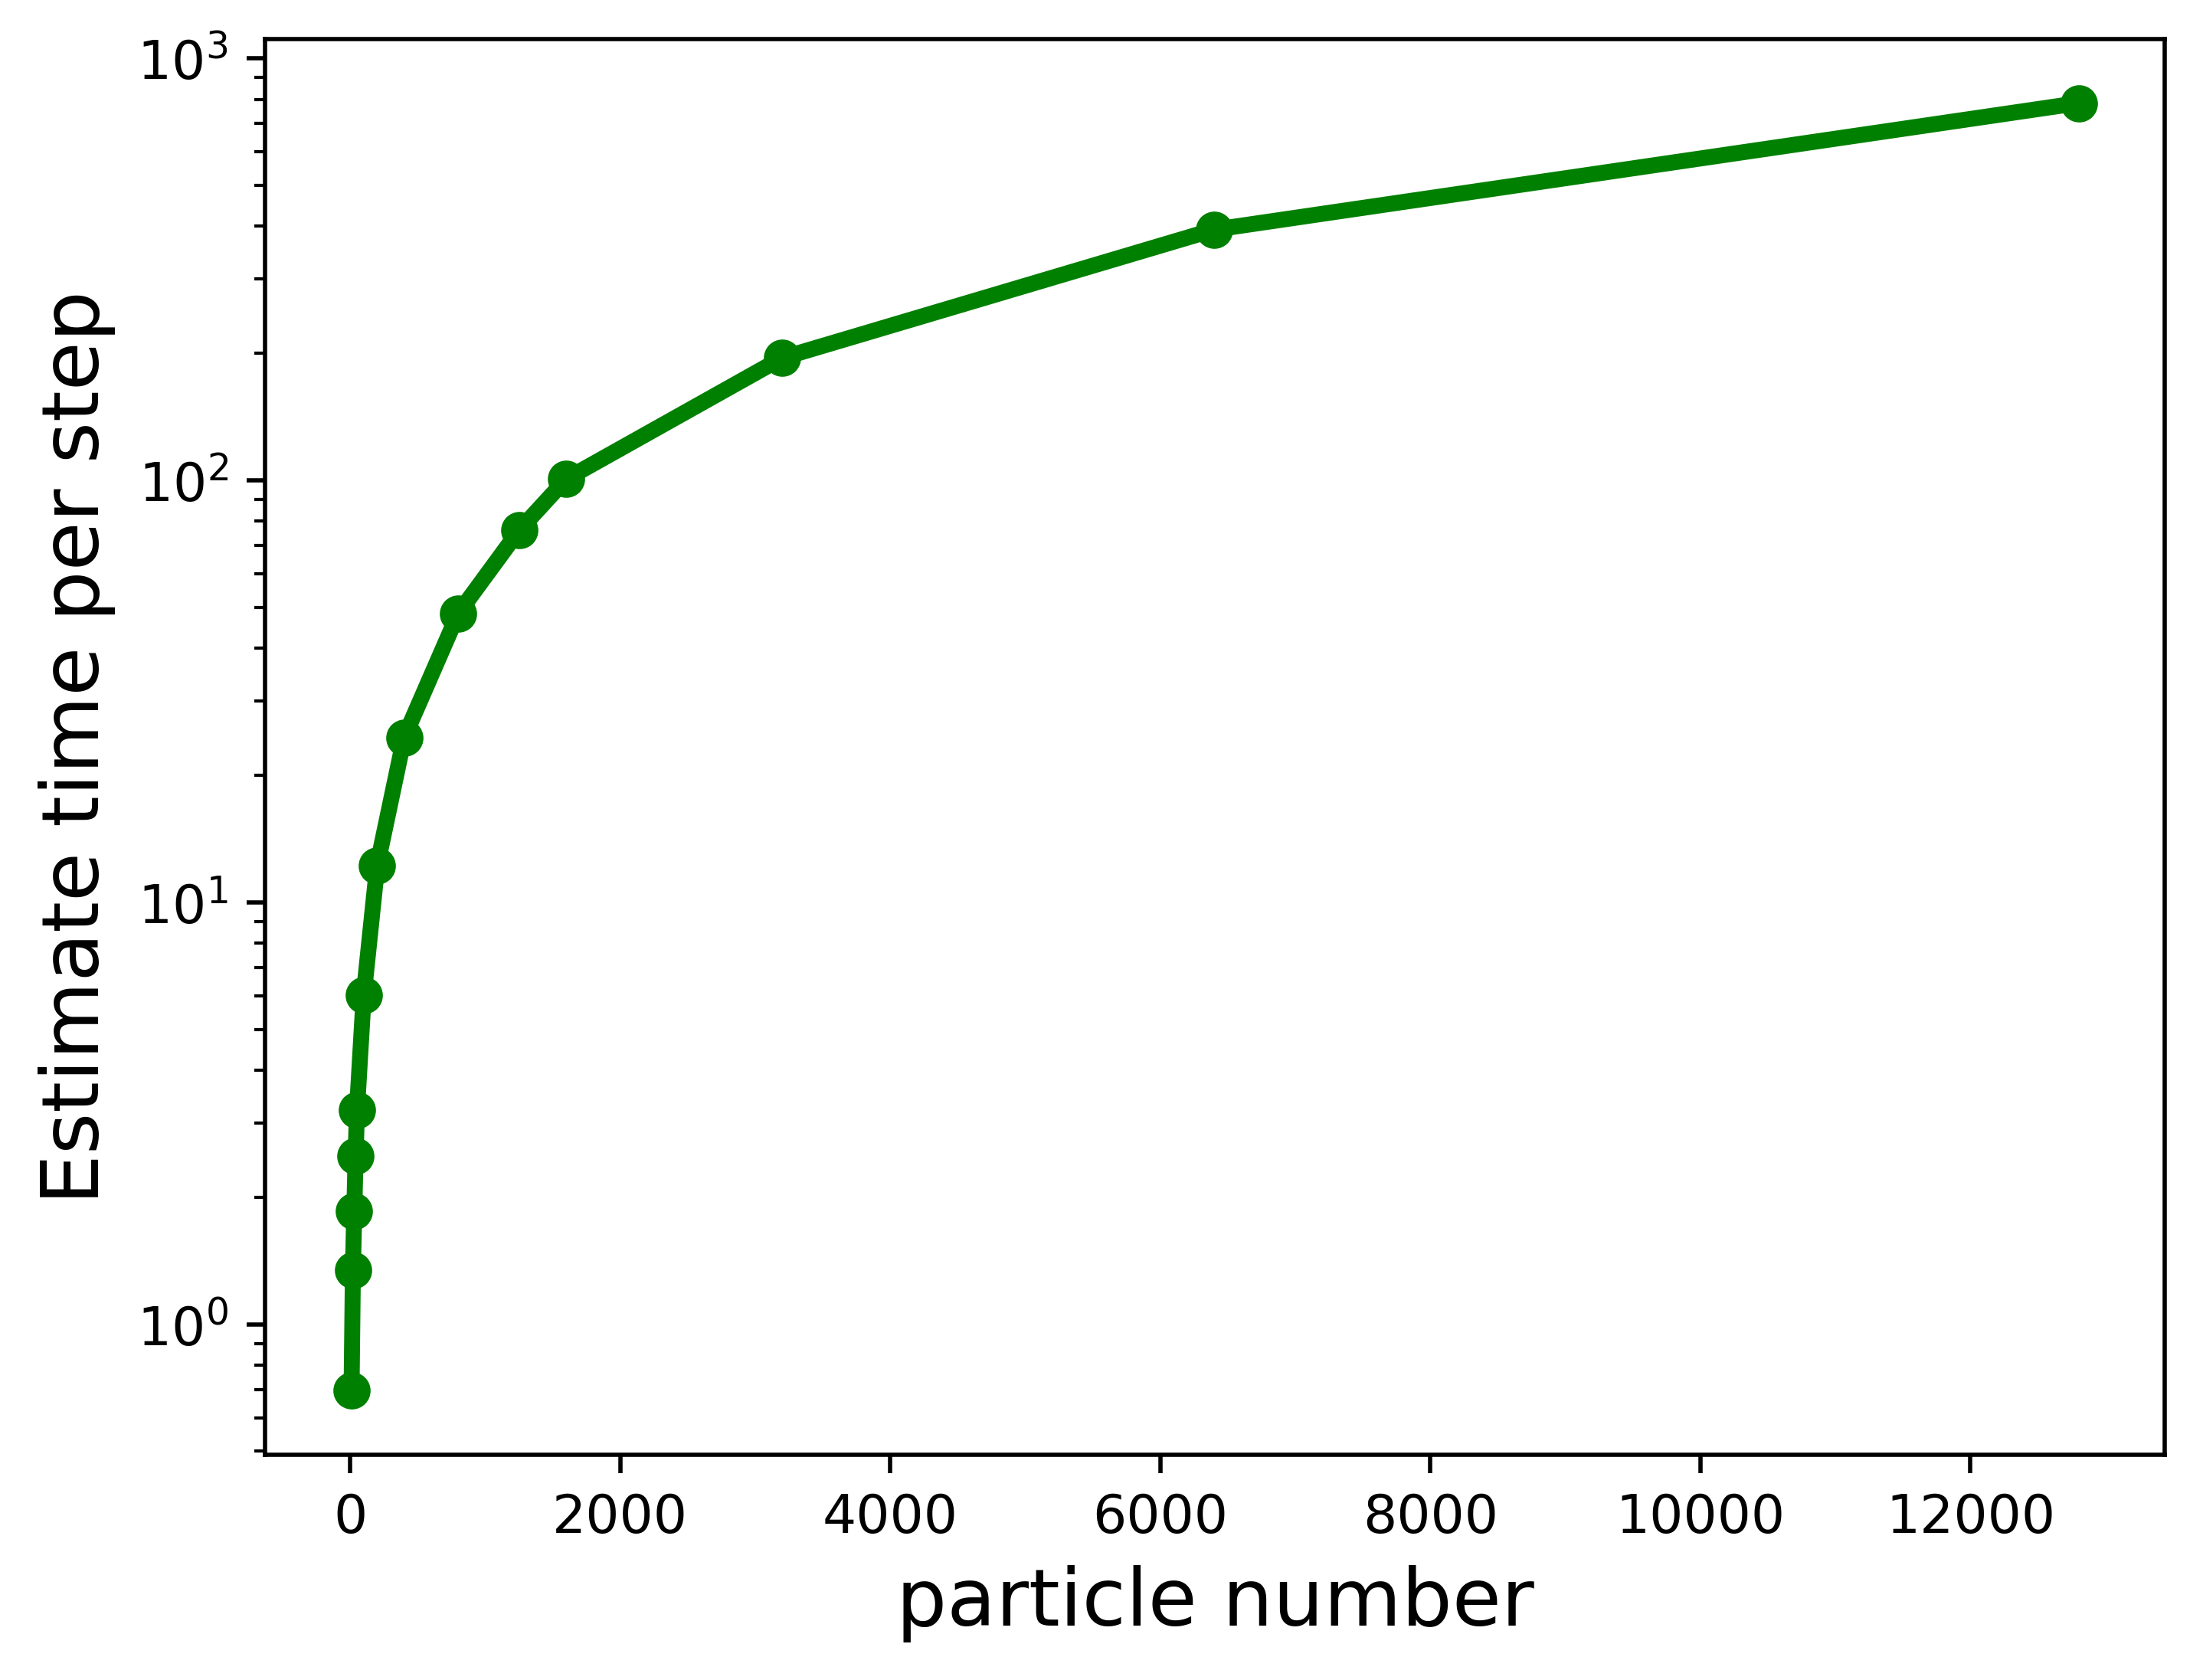

In [2796]:
plt.figure(dpi=500)
plt.plot(df_T.mean().sort_index()*1000,'o-',lw=3,color='green')
plt.xlabel('particle number',fontsize=15)
plt.ylabel('Estimate time per step',fontsize=15)
plt.yscale('log')

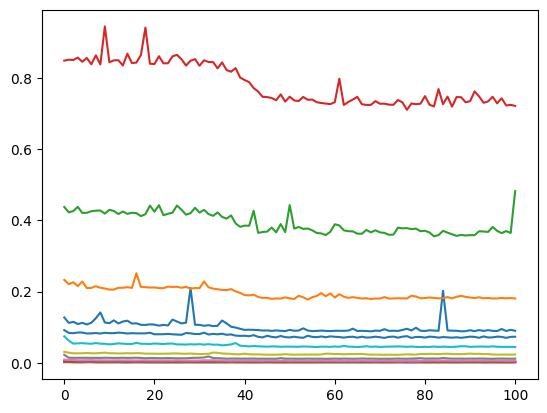

In [2783]:
plt.plot(df_T)

In [2778]:
np.mean(X_arr[-50:,-1]-K)

-2.0

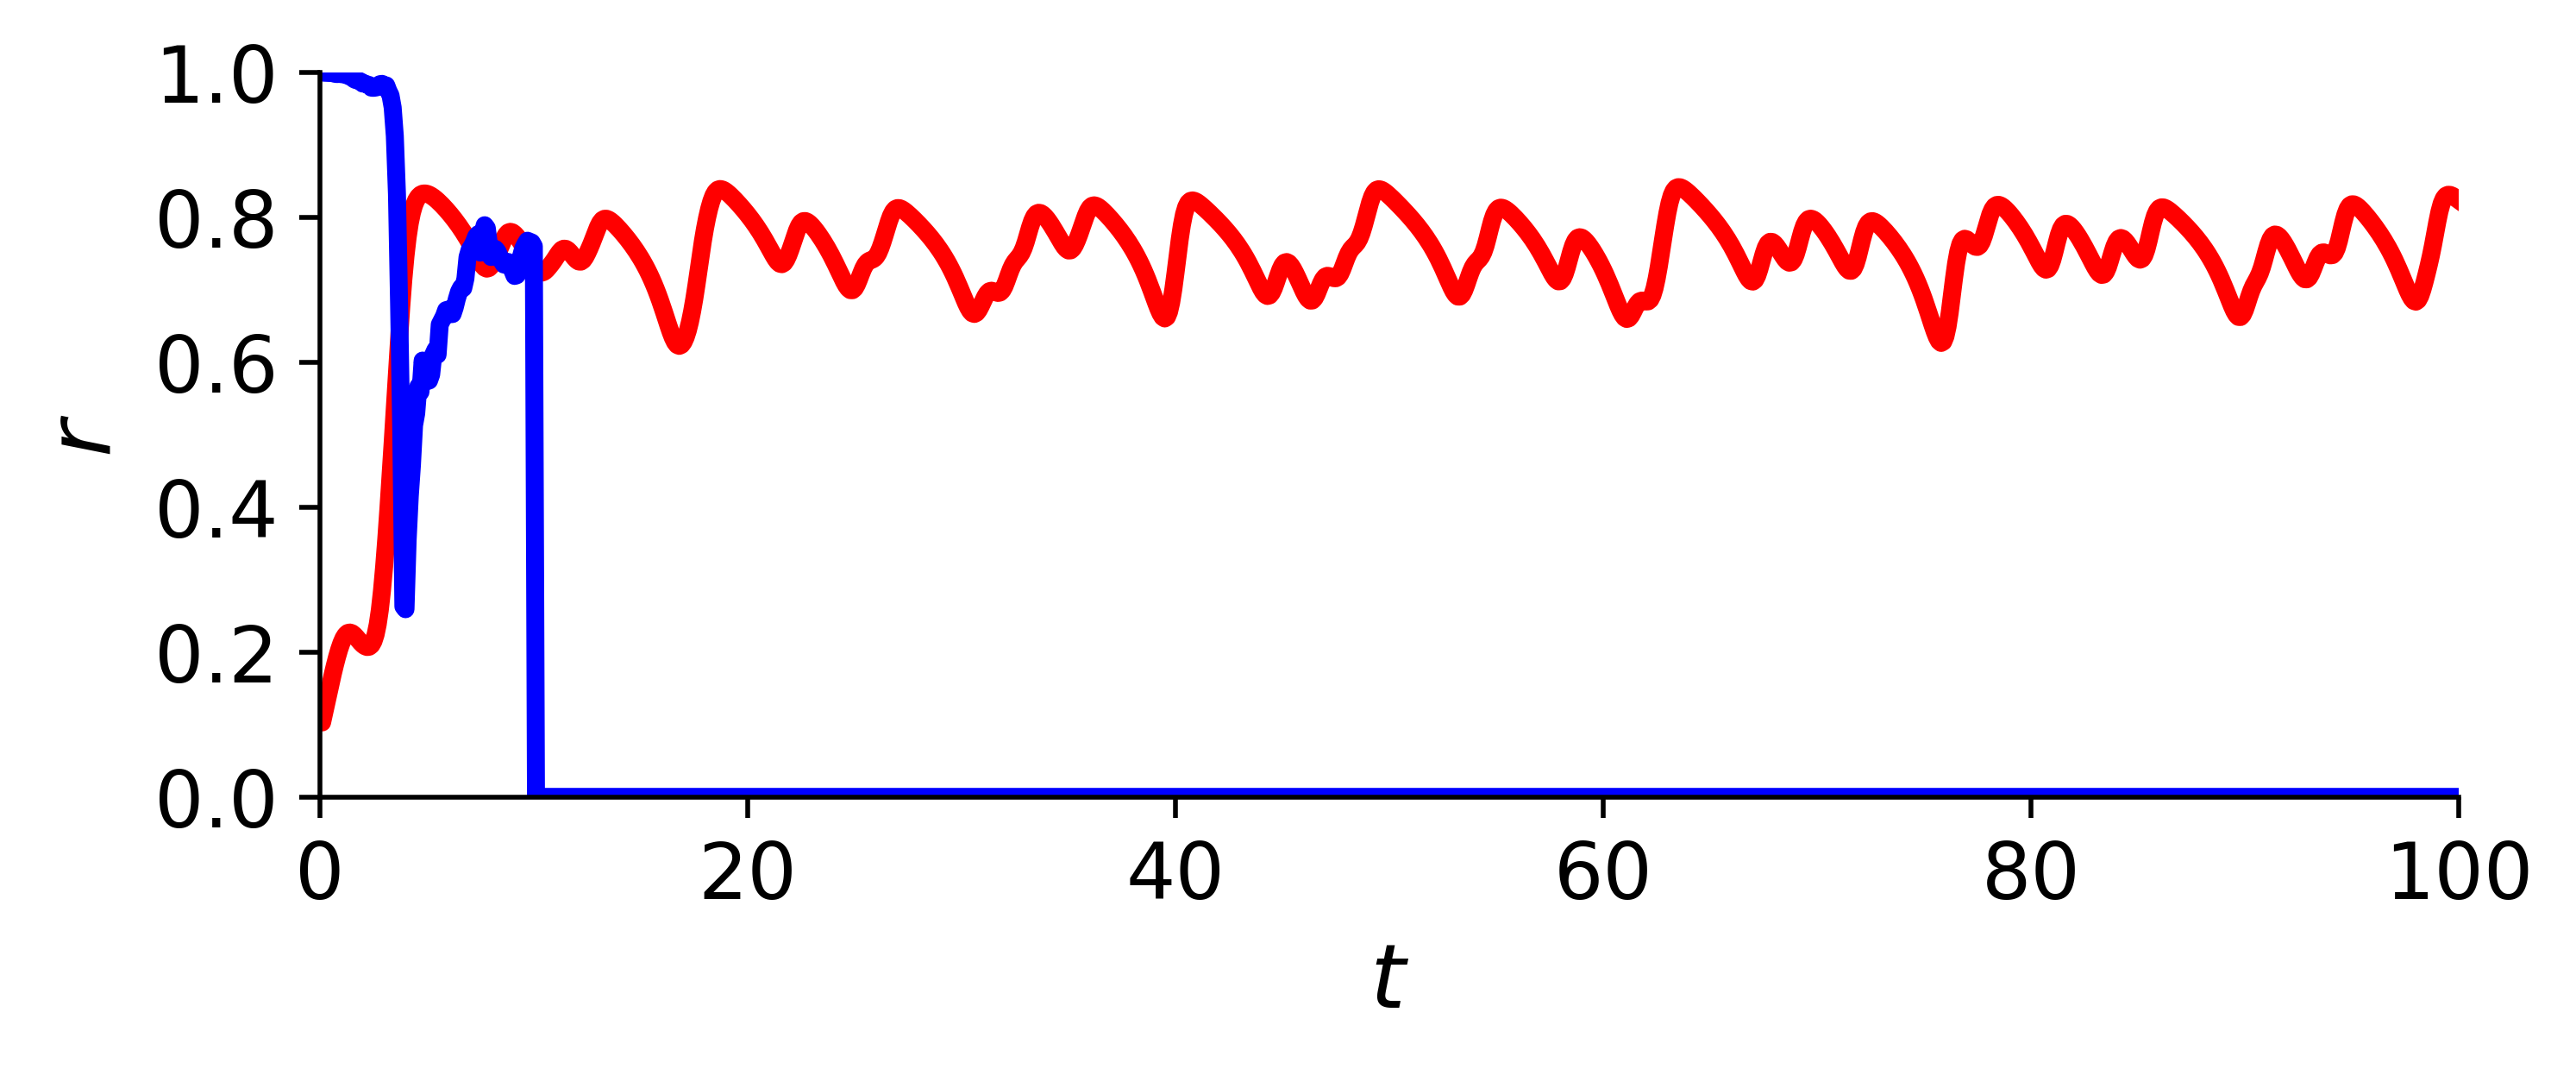

In [2779]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_arr,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

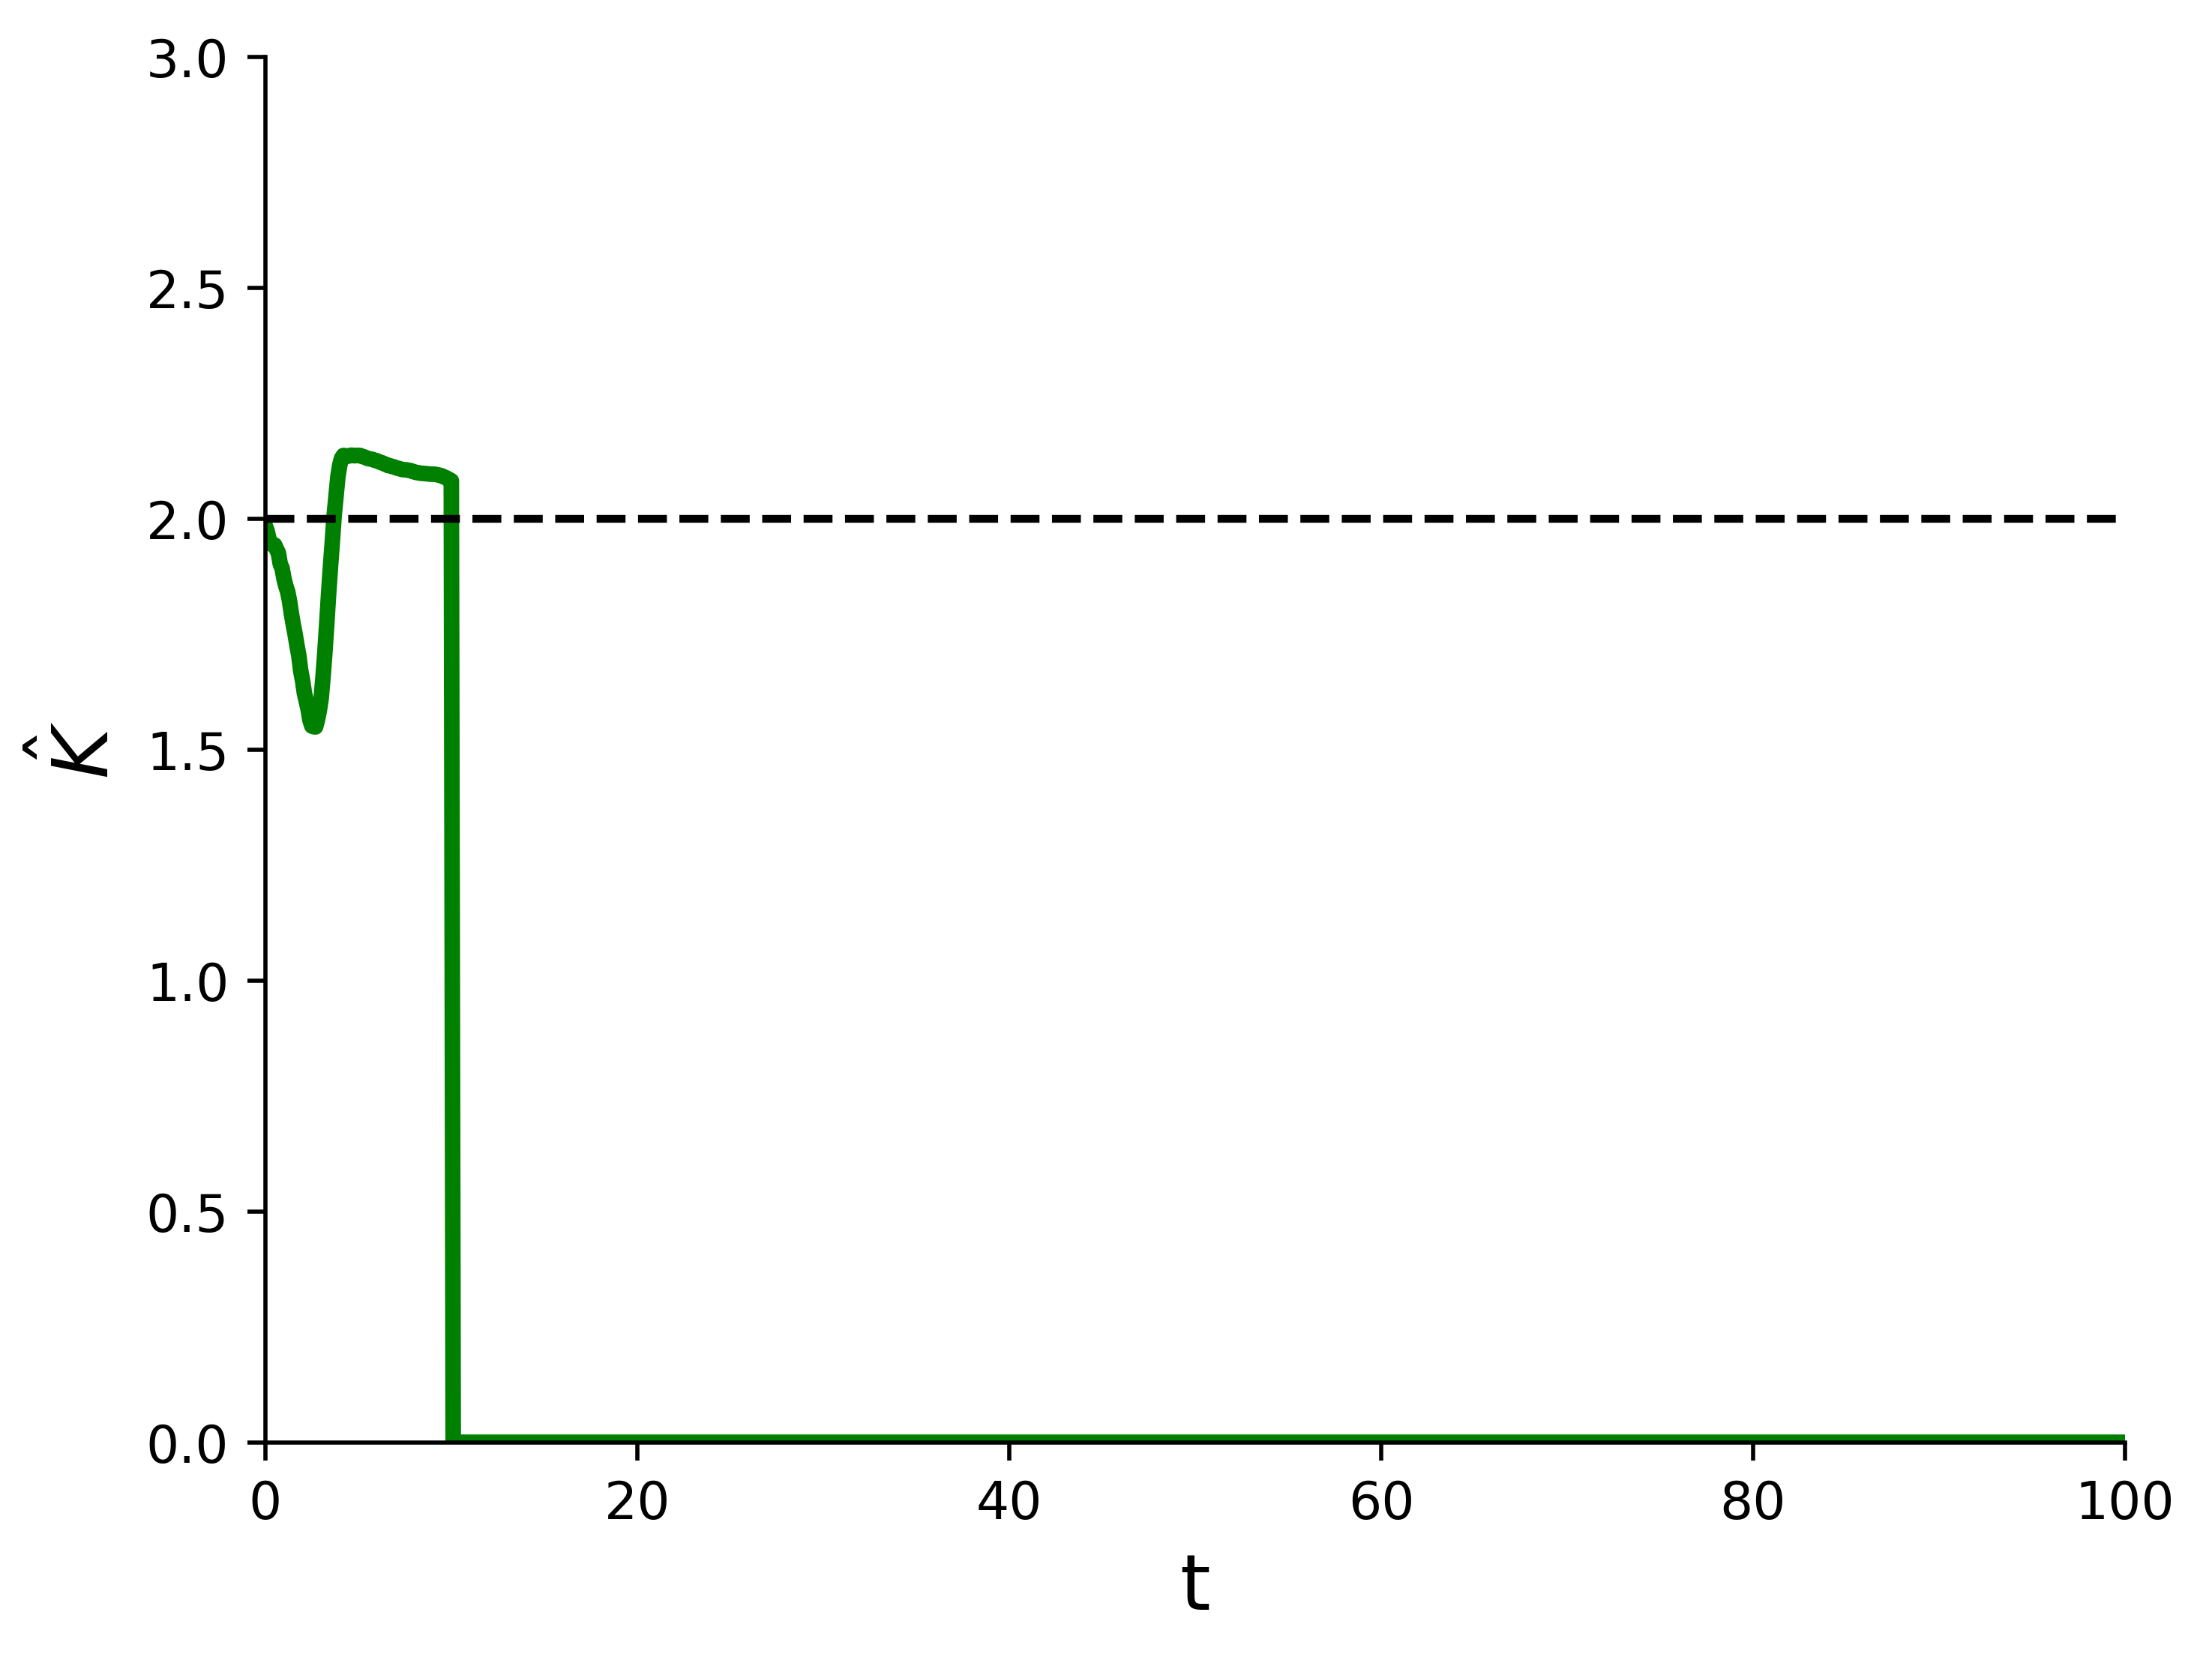

In [2780]:
plt.figure(dpi=500)
plt.plot(t,X_arr[:,-1],color='green',lw=3)
plt.axhline(K,color='black',ls='--')
plt.ylim(0,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

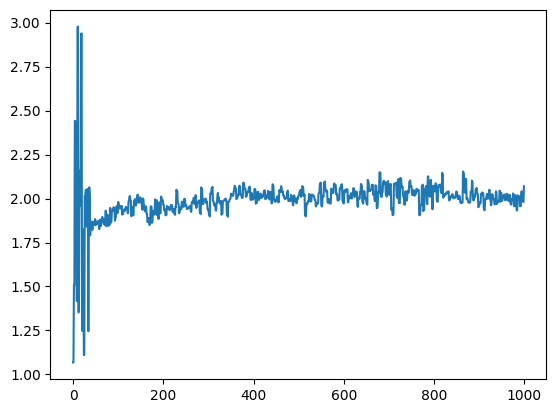

In [2749]:
plt.plot(X_arr[:,-1])

(array([  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.49, -0.39, -0.29, -0.19, -0.09,  0.01,  0.11,  0.21,  0.31,
         0.41,  0.51]),
 <BarContainer object of 10 artists>)

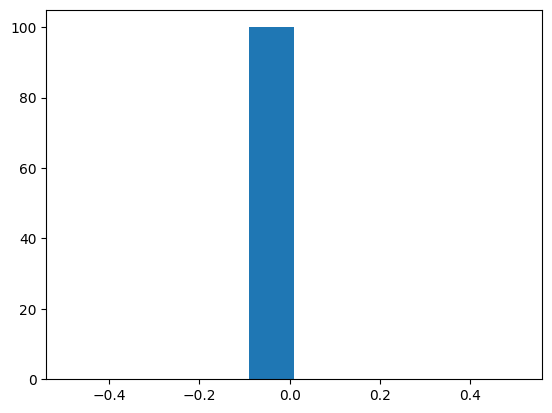

In [2636]:
plt.hist(weights)

In [2842]:
Ks = np.arange(0,4.1,0.2)
seed =11
N = 50
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0
dt = 0.1
t = np.arange(0,100,dt)
K = 1.6
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)

In [2843]:
N_p = 50
particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
for i in range(N_p):
    particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
    particles[i,N] = np.random.uniform(K-1, K+1) 

weights = np.ones(N_p)/N_p
P_arr = np.zeros((len(t),*particles.shape))
X_arr = np.zeros((len(t),N+1))

z_arr = np.zeros((len(t)))
W_arr = np.zeros((len(t),*weights.shape))
Neff_arr = np.zeros(len(t))
for num in range(len(t)):
    for i in range(N_p):
        particles[i] = f(particles[i], K_noise=0.005)

    for i in range(N_p):
        R_pred = h(particles[i])
        w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
        weights[i] *= w
    weights += 1e-30
    weights /= np.sum(weights)
    particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

    x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
    z_hat = h(x_hat)
    ESS = 1.0 / np.sum(weights**2)
    X_arr[num] = x_hat
    z_arr[num] = z_hat[0]
    P_arr[num] = particles
    W_arr[num] = weights
    if ESS < N_p * 0.7:
        indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
        particles = particles[indices]
        weights = np.ones(N_p) / N_p

# for i in range(N_p):

/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_8937/4243526698.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i] *= w


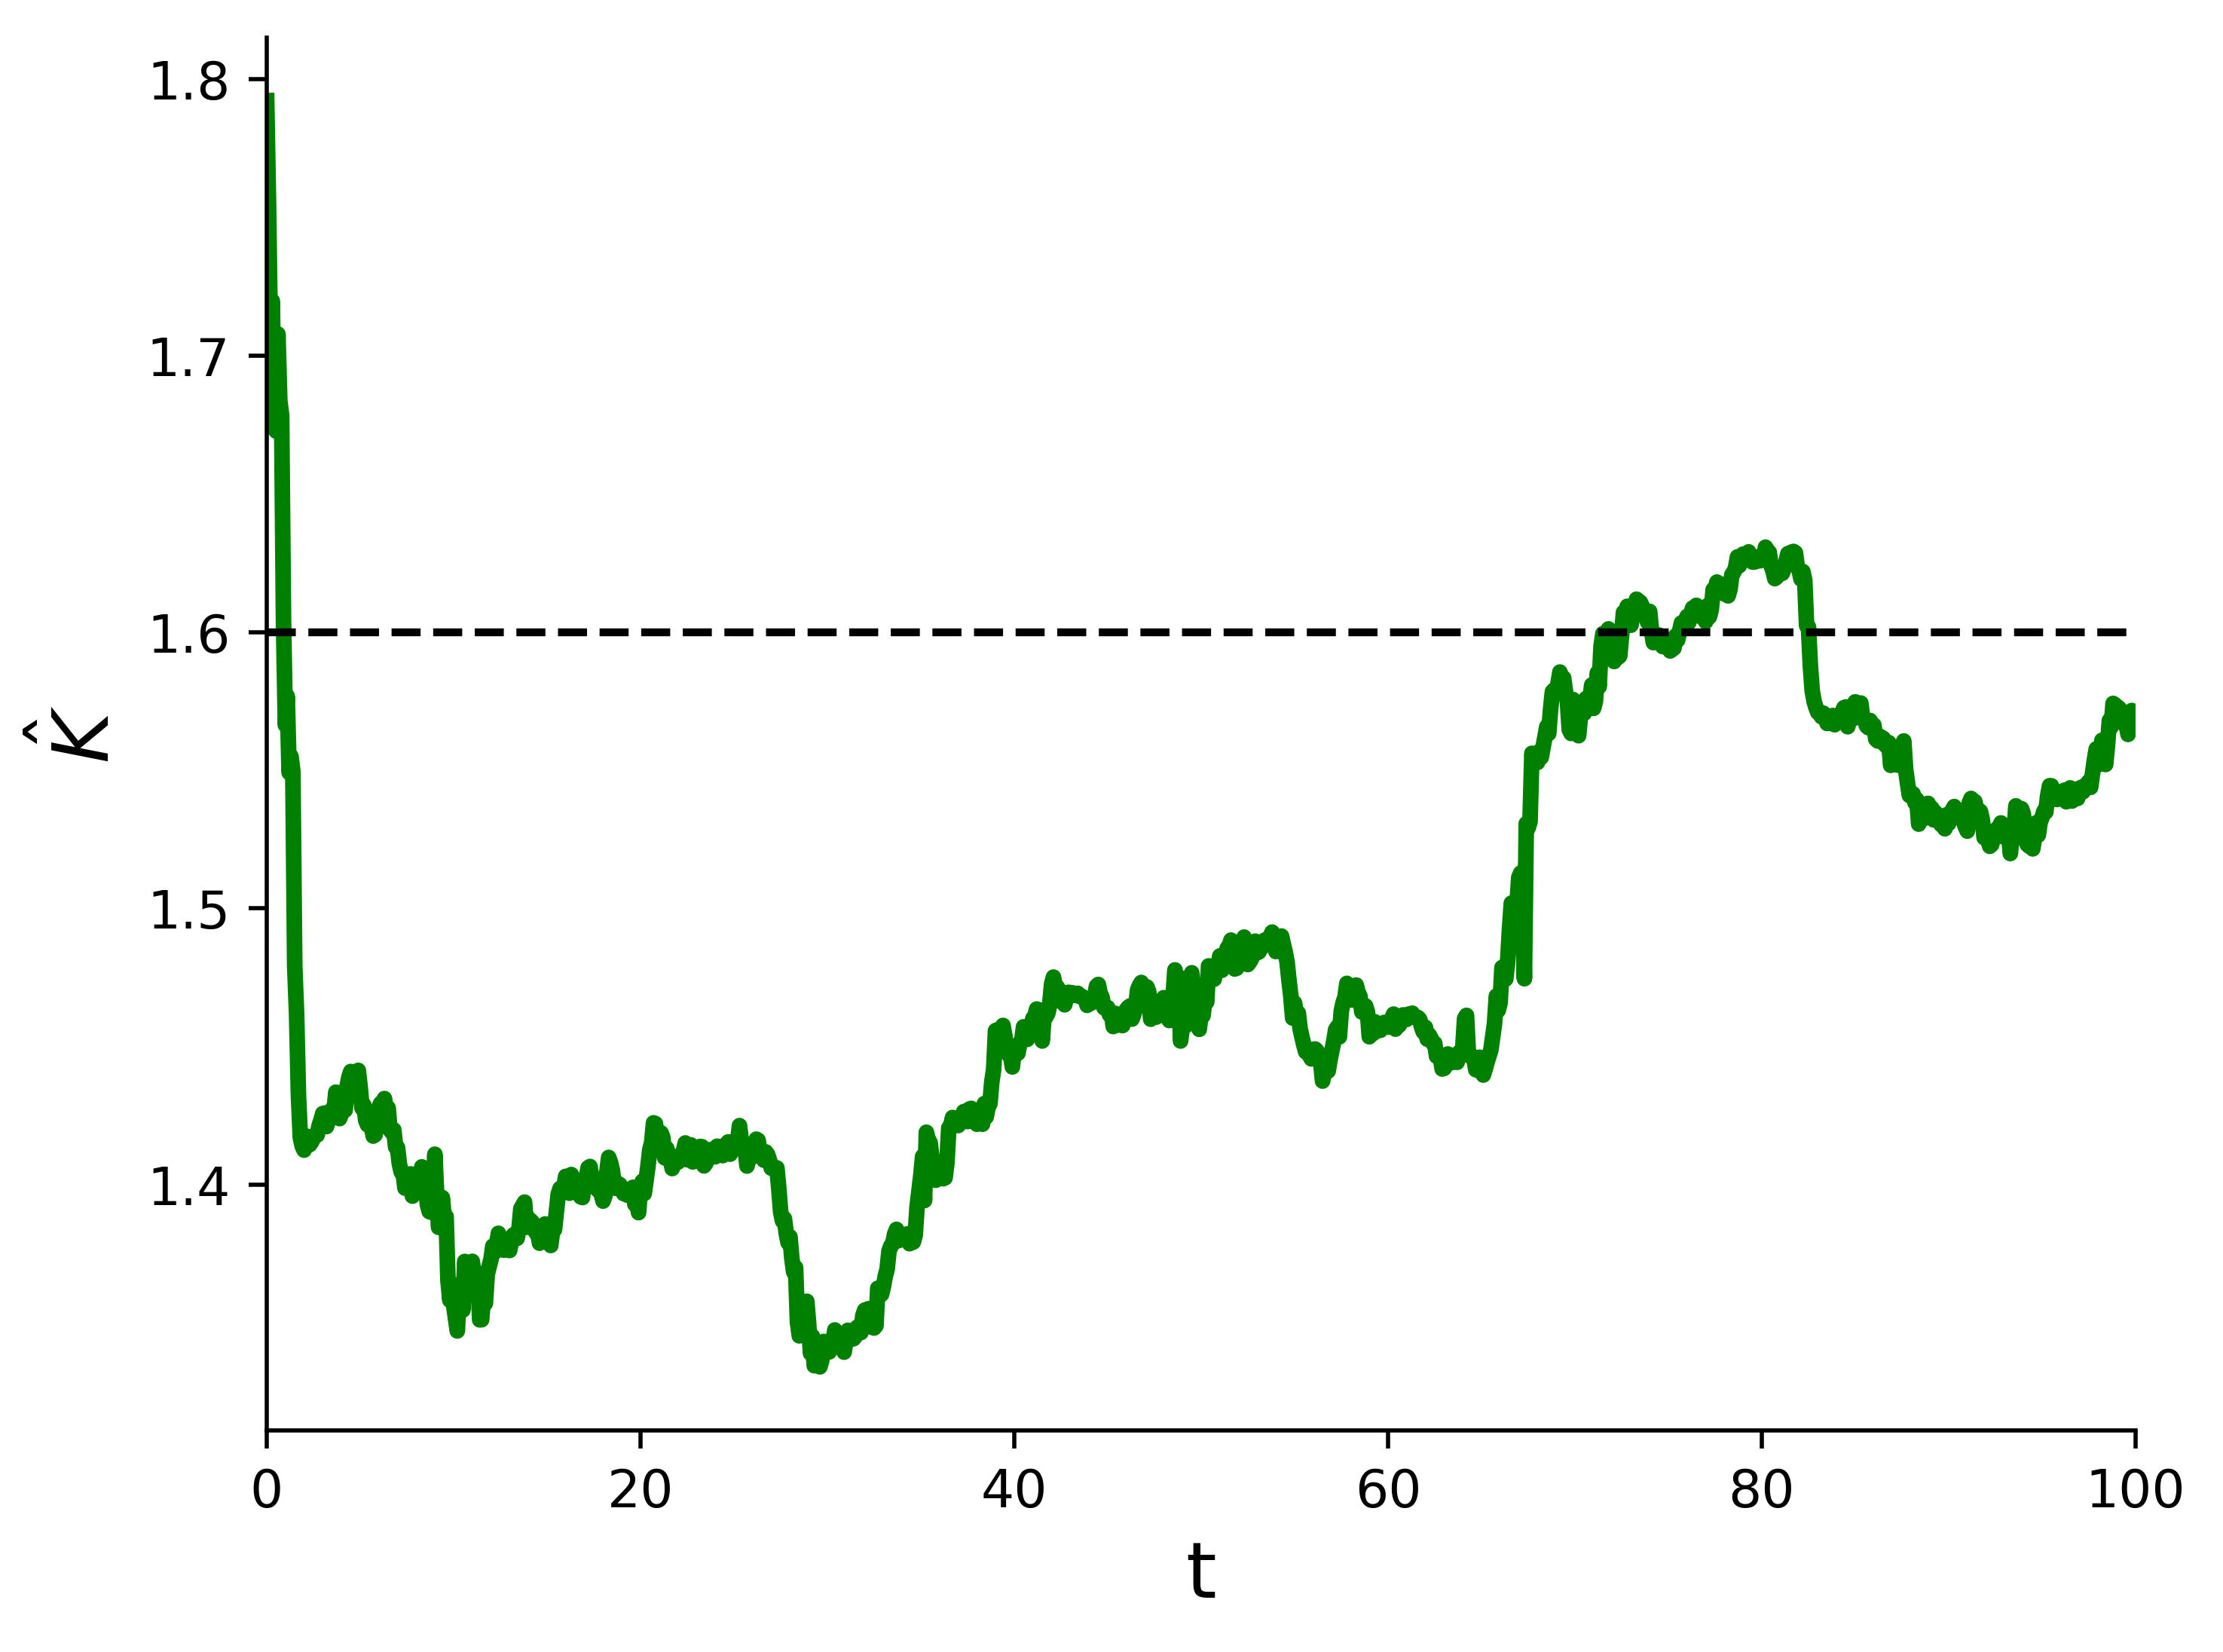

In [2844]:
plt.figure(dpi=500)
plt.plot(t,X_arr[:,-1],color='green',lw=3)
plt.axhline(K,color='black',ls='--')
# plt.ylim(0,3)
plt.xlabel('t',fontsize=15)
plt.ylabel(r'$\hat{K}$',fontsize=15)
plt.xlim(0,100)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

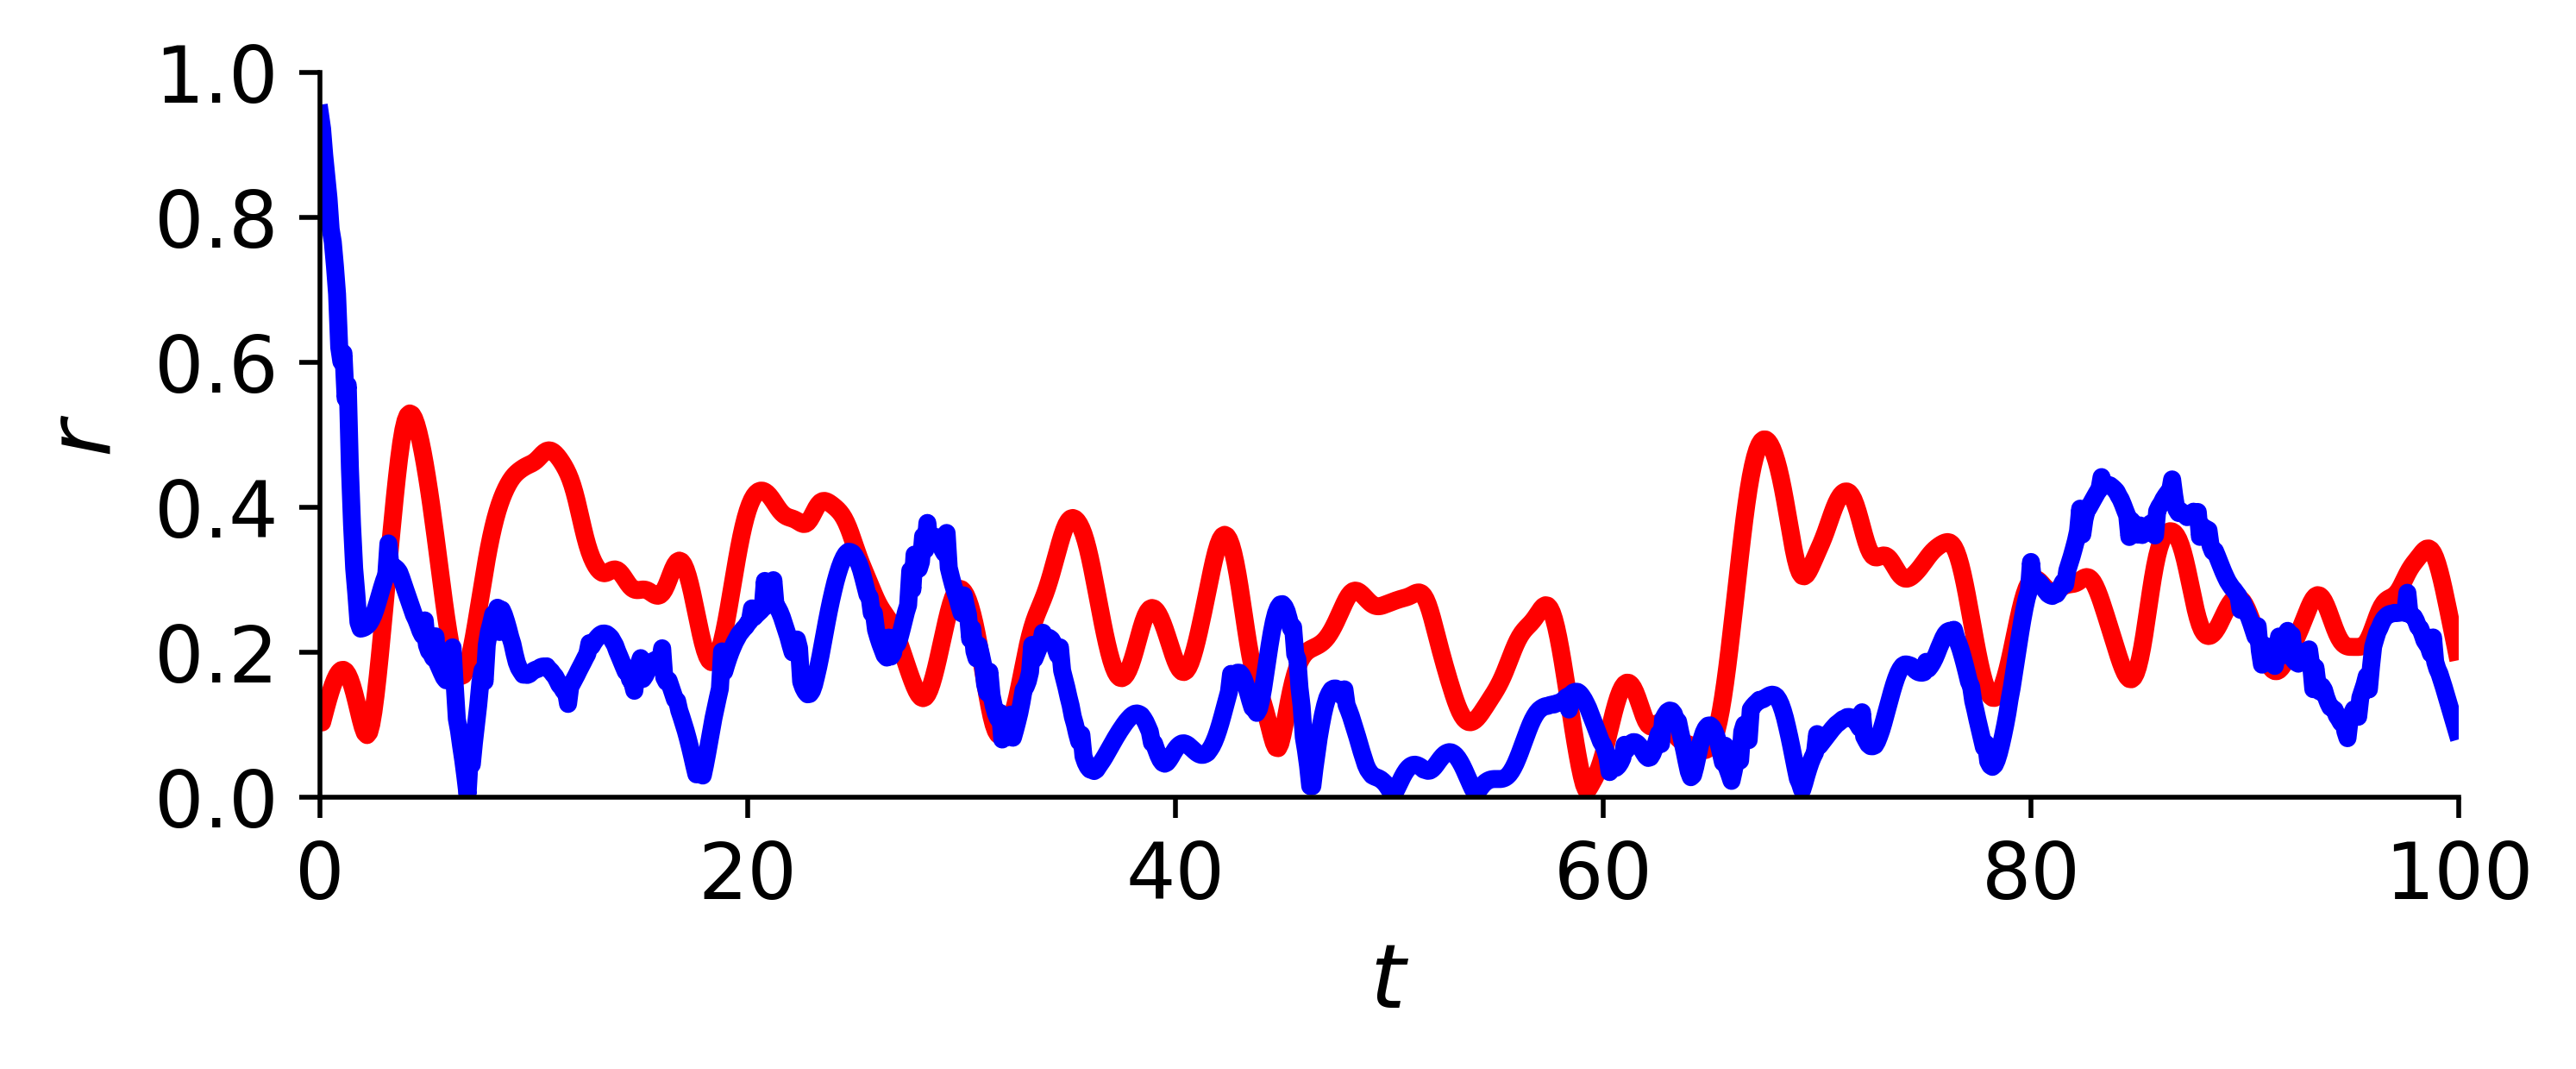

In [2845]:
plt.figure(dpi=500)
plt.subplot(211)
plt.plot(t,rs,color='red',lw=3)
plt.plot(t,z_arr,color='blue',lw=3)

plt.xlim(0,100)
plt.ylim(0,1)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [2867]:
K_rs = []
K_est_PF = {}


for K in tqdm(Ks):
    theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
    r_mean = np.mean(rs[-500:])
    K_rs.append(r_mean)
    K_est_PF['r',K] = []
    K_est_PF['K',K] = []

    
    # for num in tqdm(range(50)):
    @parfor(np.arange(50),bar=False)
    def get_r_K_mean(num,K=K):
        N_p = 250
        particles = np.zeros((N_p, N+1)) # [theta_1,...,theta_N, K]
        for i in range(N_p):
            particles[i,:N] = np.random.uniform(-np.pi, np.pi, N)
            particles[i,N] = np.random.uniform(K-1, K+1) 

        weights = np.ones(N_p)/N_p
        P_arr = np.zeros((len(t),*particles.shape))
        X_arr = np.zeros((len(t),N+1))

        z_arr = np.zeros((len(t)))
        W_arr = np.zeros((len(t),*weights.shape))
        Neff_arr = np.zeros(len(t))
        for num in range(len(t)):
            for i in range(N_p):
                particles[i] = f(particles[i], K_noise=0.005)

            for i in range(N_p):
                R_pred = h(particles[i])
                w = likelihood(rs[num] + np.random.randn() * np.sqrt(R_meas), R_pred, R_meas)
                weights[i] *= w
            weights += 1e-30
            weights /= np.sum(weights)
            particles[:, :N] = (particles[:, :N] + np.pi) % (2 * np.pi) - np.pi

            x_hat = np.sum(particles * weights[:, np.newaxis], axis=0)
            z_hat = h(x_hat)
            ESS = 1.0 / np.sum(weights**2)
            X_arr[num] = x_hat
            z_arr[num] = z_hat[0]
            P_arr[num] = particles
            W_arr[num] = weights
            if ESS < N_p * 0.5:
                indices = np.random.choice(np.arange(N_p), size=N_p, p=weights)
                particles = particles[indices]
                weights = np.ones(N_p) / N_p
        

        K_est_PFm = np.mean(X_arr[-50:,-1]) 
        r_estm = np.mean(z_arr[-50:]) 
        return K_est_PFm,r_estm
    K_est_PFs,r_ests = zip(*get_r_K_mean)
    print(K_est_PFs,r_ests)
    K_est_PF['K',K] = K_est_PFs
    K_est_PF['r',K] = r_ests

  0%|          | 0/21 [00:00<?, ?it/s]

(-0.8814932612772531, -1.1421288110629626, -0.9552022870602686, -0.7400855505366353, -1.2789006306636148, -0.5168946853550829, -0.6843435879179343, -0.9611355287855556, -0.6554340577553619, -0.23598171213881577, -0.960489160559749, -0.8295937933606247, -0.3879815536638741, -0.22207740312430832, -0.8921177740236657, -0.7466424644002307, -0.976709754077368, -1.054037999472631, -0.7699679843582302, 0.20993150844369401, 0.14698831638652762, -1.1193948355600538, -0.7168561288992555, 0.33067358810007114, 0.1418863583865426, -0.5518021158421861, -0.6513157600880551, -0.5730248377990751, -0.9487518026103762, -1.0550233909964235, -0.5092206733515889, -0.8673601700820156, -0.439502318988092, -1.0736788014166192, -1.0421399999705678, -0.4714396675966879, -0.5247711365639536, -0.31414294251850483, -0.7790692164775157, -0.868522456101681, -1.0241887567156642, -0.6616865819260107, -0.282541963881719, -0.7444324816826764, -0.46954263016998754, -0.6709254418244656, 0.11595505229476359, -0.440281892227

In [2869]:
df_PF = pd.DataFrame(K_est_PF)

In [2870]:
df = df_PF.copy()

In [2871]:
# IQR 계산
Q1 = df['K'].quantile(0.25)
Q3 = df['K'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 정의
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 각 column마다 이상치를 NaN으로 대체
for col in df['K'].columns:
    df['K', col] = df['K', col].apply(lambda x: x if lower_bound[col] <= x <= upper_bound[col] else np.nan)
    df['r', col] = df['r', col].where(df['K', col].notna(), np.nan)

In [2872]:
df['K']

,0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,...,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0
0,-0.881493,0.547832,-0.747592,-0.394636,-0.228279,0.346527,1.271938,1.520937,1.587420,NaN,...,NaN,2.415892,2.576588,2.863695,3.057024,3.351775,3.444457,3.901362,3.883959,4.051828
1,-1.142129,-0.919050,-0.282604,-0.221937,0.136447,0.607806,1.344435,1.066447,1.630797,1.840688,...,2.214566,2.443468,2.602798,NaN,3.121346,3.415495,3.263285,3.610655,4.392355,4.270378
2,-0.955202,-0.787434,-0.449730,0.163786,0.162569,1.072899,0.931616,0.373996,1.681463,1.839981,...,2.205669,2.421878,NaN,2.768174,3.113278,3.260905,3.675415,3.525235,3.608706,4.378662
3,-0.740086,0.016650,-0.394836,0.261141,0.249184,1.331563,0.696254,0.657301,1.697881,1.919101,...,2.199182,NaN,2.583884,2.829708,2.973324,3.009550,3.212804,3.906623,3.670597,3.993206
4,-1.278901,-0.560817,-0.160513,0.887182,0.458065,0.619236,0.242355,1.304944,1.618976,1.899686,...,2.221997,2.413780,2.636083,2.795947,3.045510,3.185386,3.484174,3.245378,3.912765,4.779491
5,-0.516895,-0.307515,0.364085,0.262381,0.130982,-0.023416,0.590947,0.233400,1.614724,1.888421,...,2.206352,2.425886,2.612760,2.932895,3.133205,3.465830,3.296806,3.798020,NaN,4.258767
6,-0.684344,-0.905688,0.771009,0.184088,0.885056,0.803814,1.210234,1.122419,1.578027,NaN,...,2.210291,2.427551,2.583084,2.731878,3.114070,3.191082,3.785062,3.523050,3.664664,4.618775
7,-0.961136,-1.184395,-0.577019,0.001921,0.826617,0.944853,1.406269,0.826146,1.543325,1.790854,...,2.202247,2.415588,2.629772,2.765205,2.973367,3.350133,3.486126,3.751760,3.622921,4.498647
8,-0.655434,-0.162220,-0.028679,0.088080,0.649121,0.879737,0.608761,1.012445,1.511831,1.870970,...,2.185001,2.393195,2.587463,2.893593,3.067741,3.171075,3.564537,3.773831,4.062506,4.078379
9,-0.235982,-0.258362,0.487431,0.185681,0.331998,0.025574,1.124490,0.541273,1.576948,1.830494,...,2.193807,2.413433,2.633813,2.758022,3.014779,2.989804,3.346218,3.899184,4.120432,4.234990


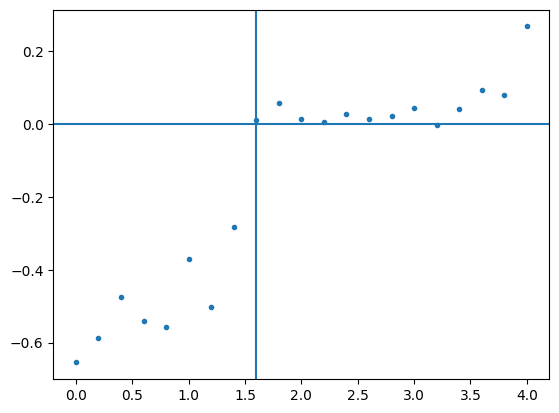

In [2873]:
KK = df['K'].to_numpy()
K_mean =np.nanmean(KK,axis=0)
K_std =np.nanstd(KK,axis=0)
plt.plot(Ks,K_mean-Ks,'.')
# plt.ylim(-1,1)
# plt.fill_between(Ks,K_mean-K_std,K_mean+K_std,alpha=0.3)
# plt.plot(Ks,Ks)
plt.axhline(0)
plt.axvline(K_c)

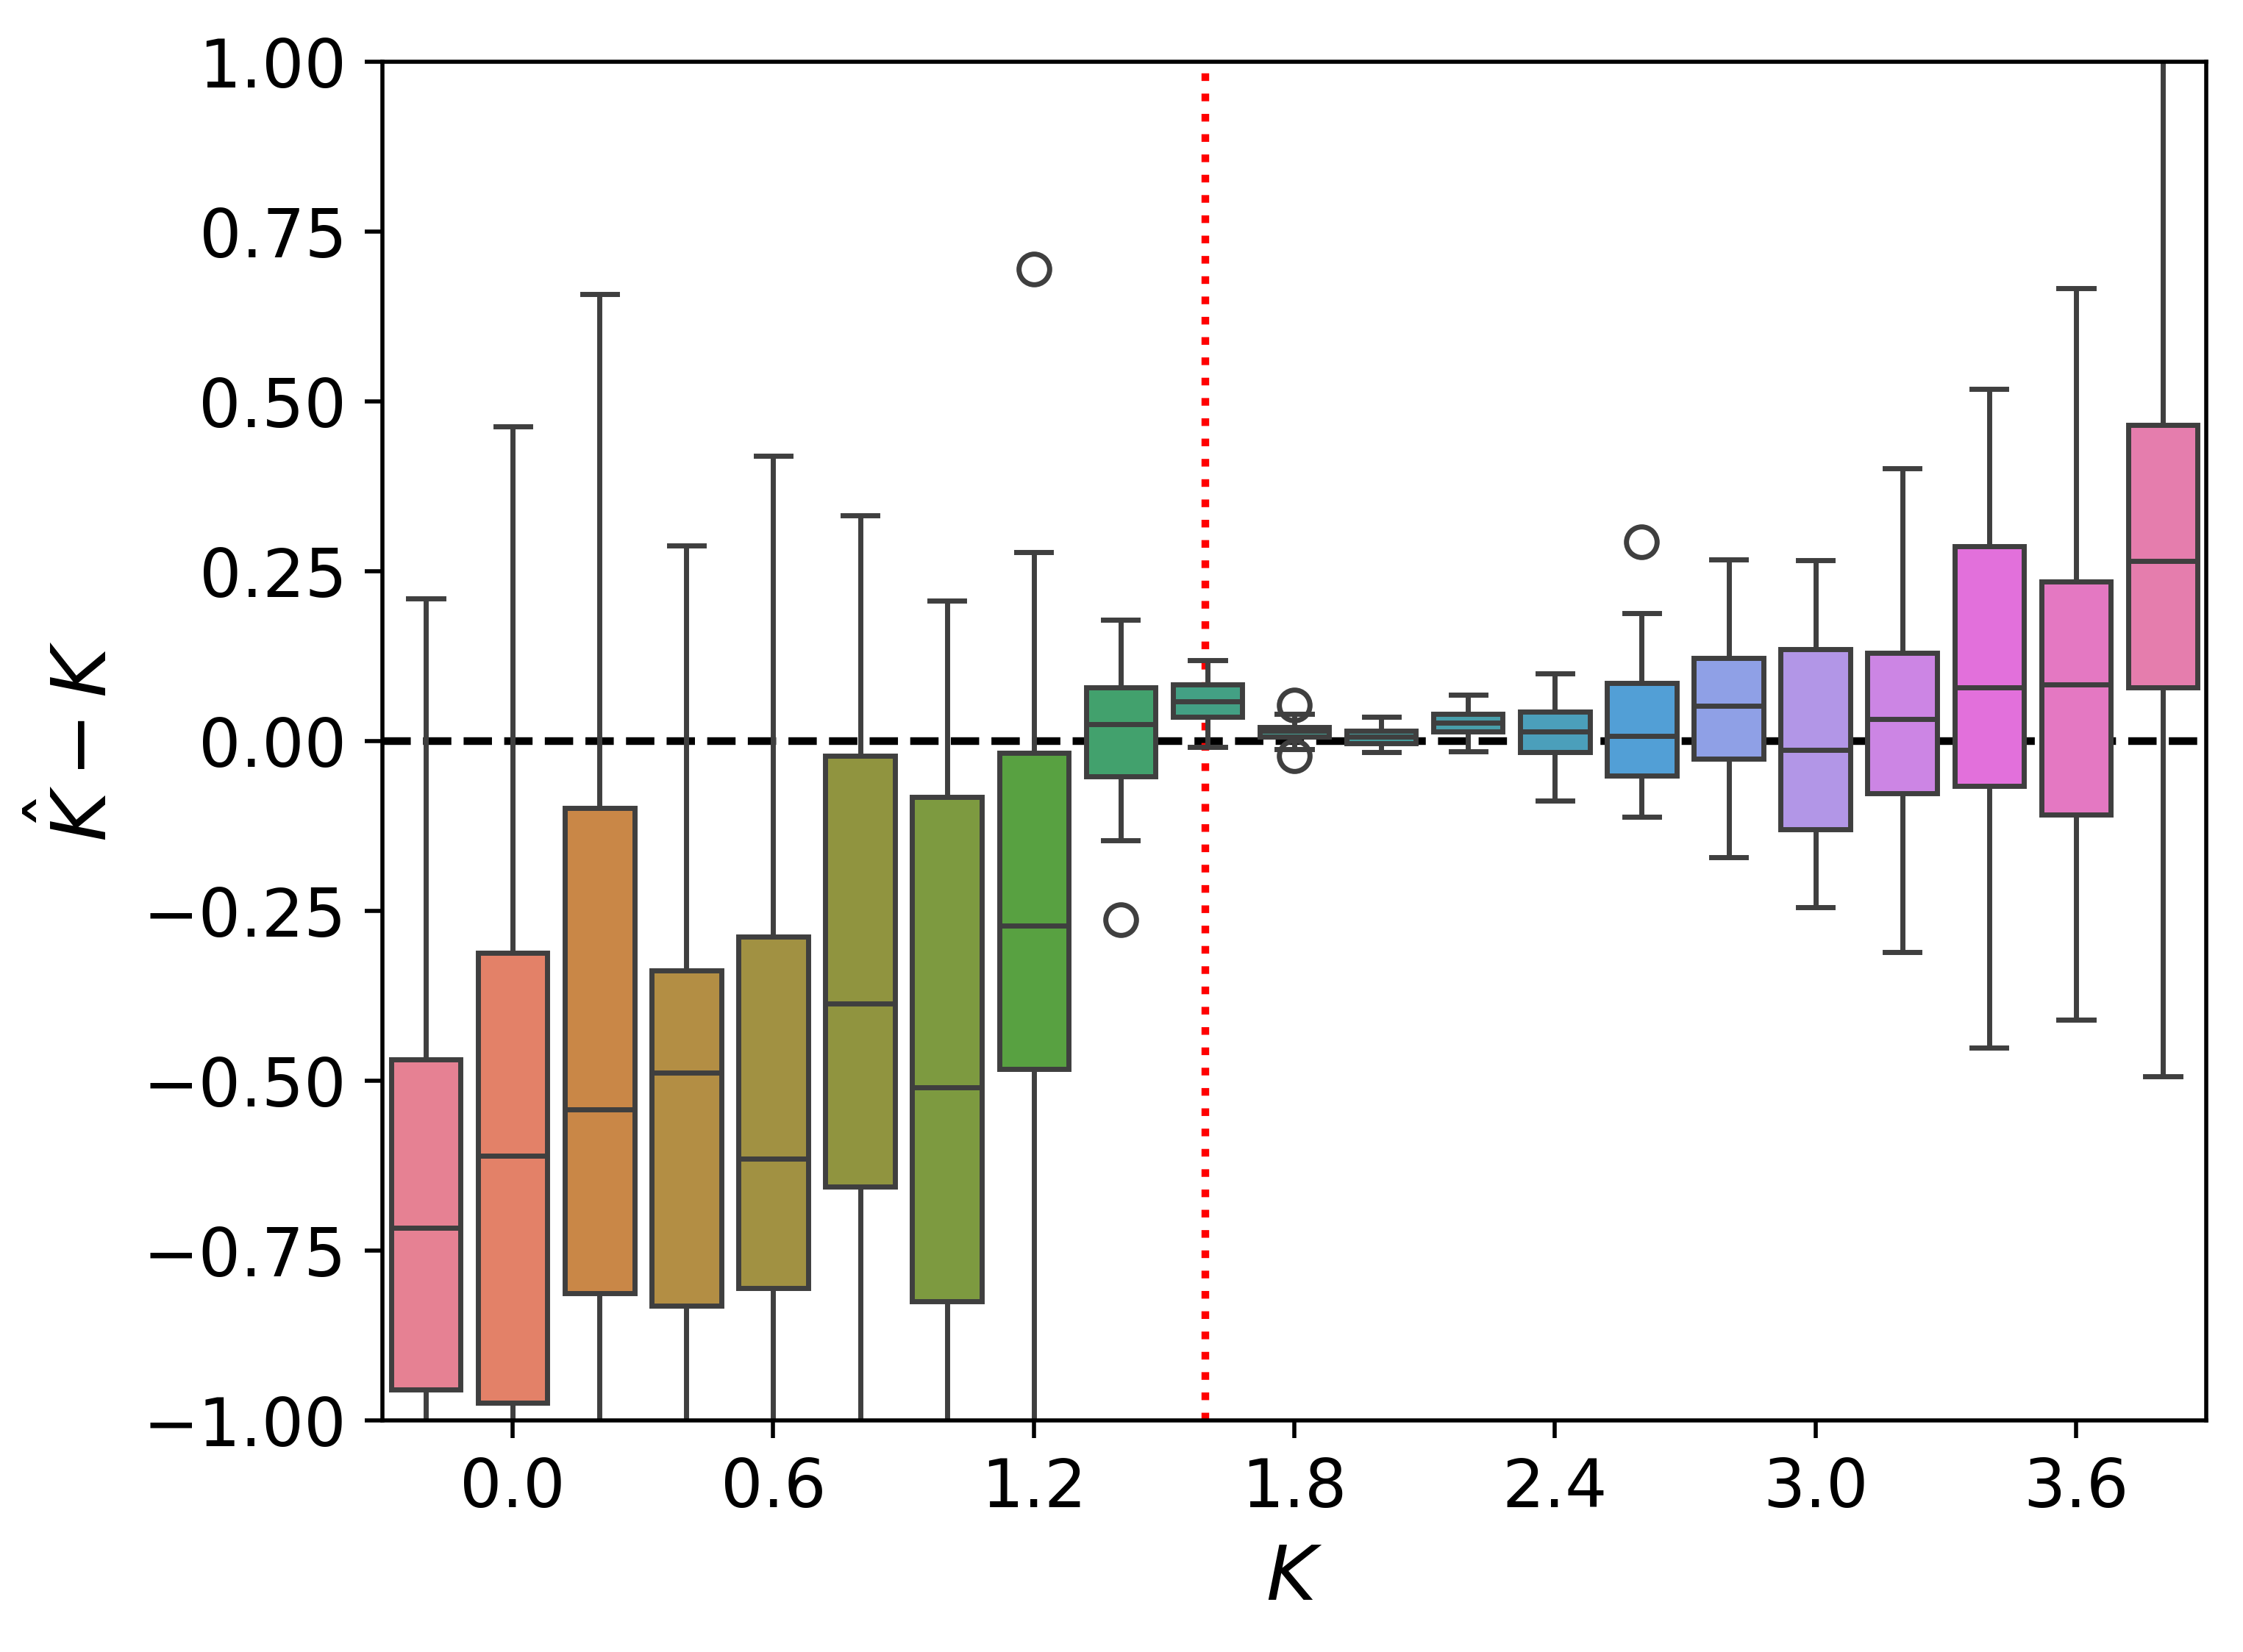

In [2874]:
# plt.plot(Ks,(KK-Ks).T,'.');
plt.figure(dpi=500)
sns.boxplot(data=(KK-Ks))
plt.xticks((np.arange(21)+1)[::3],[0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6])
plt.axhline(0,zorder=-10,ls='--',color='black')
plt.axvline(K_c/0.2+1,zorder=-10,ls=':',color='red')
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$\hat{K} - K$',fontsize=15)
plt.ylim(-1,1)
# plt.title('Box plot of KK - Ks')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

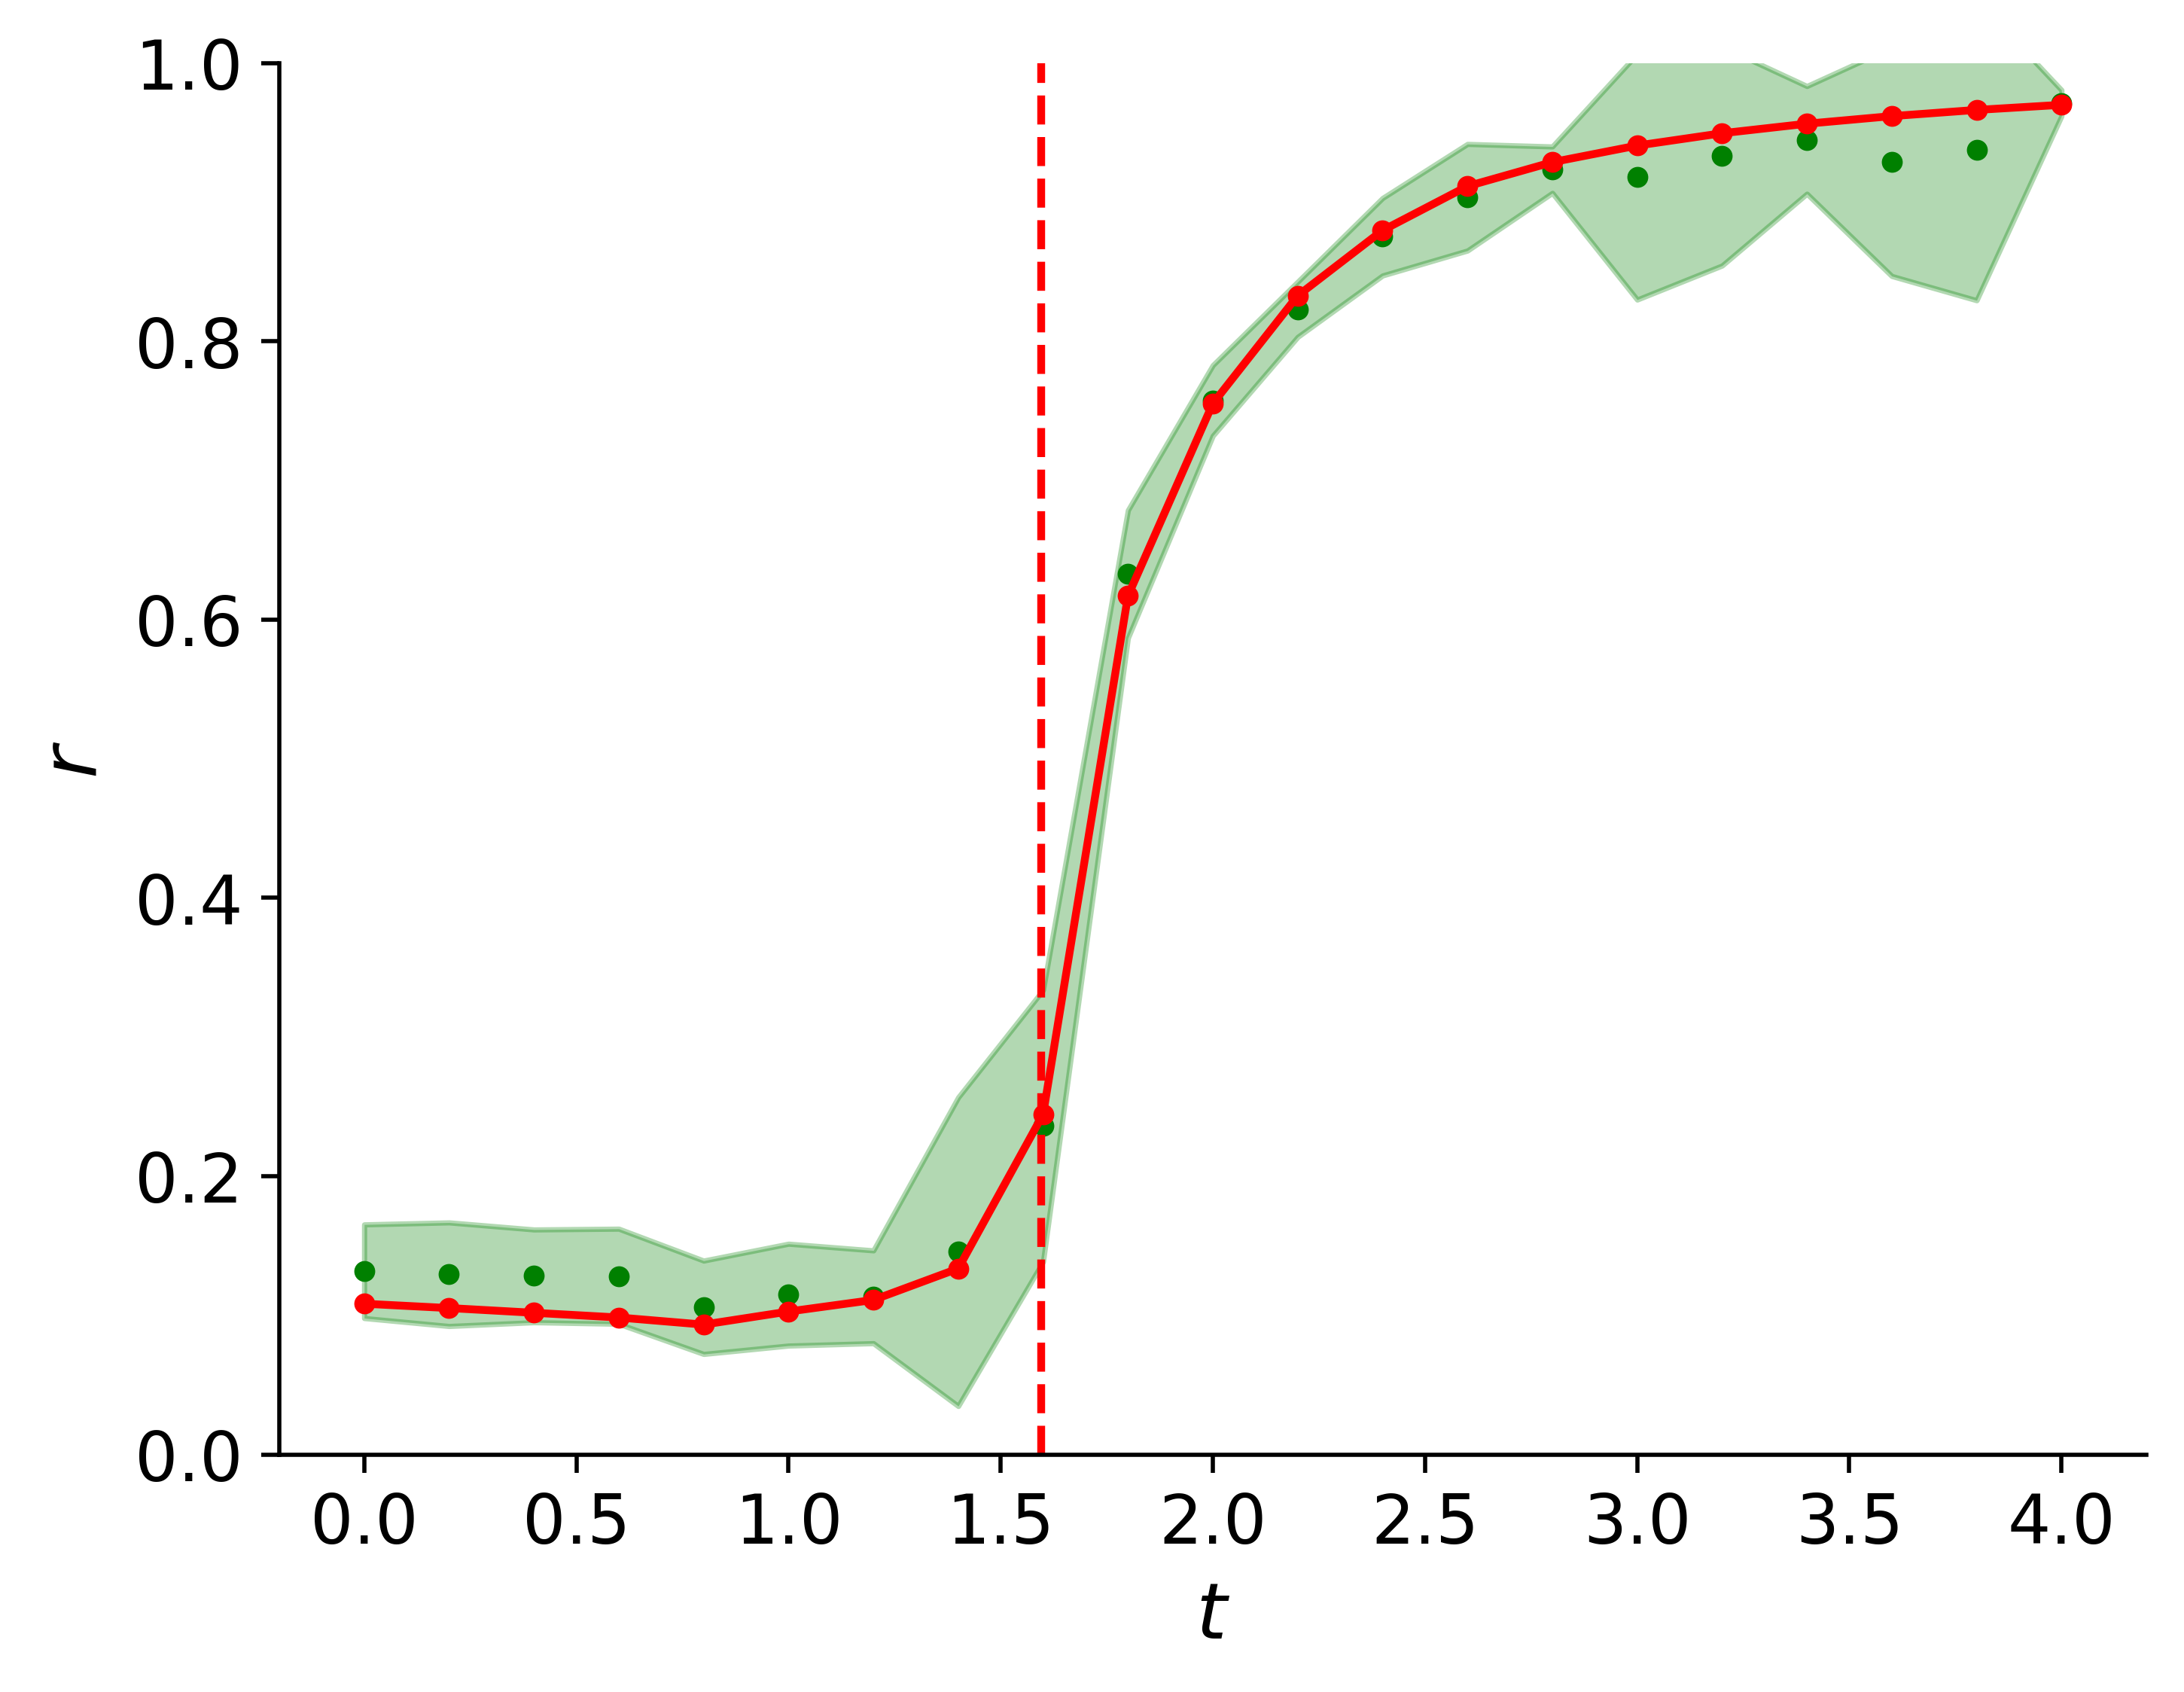

In [2875]:
plt.figure(dpi=500)
rr = df['r'].to_numpy()
r_mean =np.nanmean(rr,axis=0)
r_std =np.nanstd(rr,axis=0)
plt.plot(Ks,r_mean,'.',color='green')
plt.fill_between(Ks,r_mean-r_std,r_mean+r_std,alpha=0.3,color='green')
plt.plot(Ks,K_rs,'.-',color='red')
plt.ylim(0,1)
# plt.axhline(0)
plt.axvline(K_c,ls='--',color='red')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)